In [1]:
import matplotlib.pyplot as plt
%pylab inline
import pandas as pd
import numpy as np
import scipy.stats as ss
import pickle
import statsmodels
from statsmodels.tsa.api import ARIMA, acf, pacf, datetools
import statsmodels.api as sm
from scipy import signal
import scipy as sc
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
from statsmodels.graphics.regressionplots import plot_leverage_resid2
import seaborn as sns
from itertools import product

Populating the interactive namespace from numpy and matplotlib


Загружаем данные о количество поездок в 102 регионах, выбранных на 2 неделе.

In [2]:
with open("./data/all_regions.pkl", "rb") as fid:
    data = pickle.load(fid)

In [3]:
data.transpose().shape

(21888L, 102L)

Загрузим и идентификаторы оставшихся регионов.

In [4]:
with open("./data/regions_left.pkl", "rb") as fid:
    regions = np.array(pickle.load(fid)) + 1

Создаем таблицу. По строкам у нас время, а по столбцам идентификатор ячейки.

In [5]:
p = pd.date_range('2014-01-01 00:00:00', periods=data.shape[1], freq='H')
df = pd.DataFrame(data.transpose(), index=p, columns=regions)
df.head()

,1075,1076,1077,1125,1126,1127,1128,1129,1130,1131,...,1630,1684,1733,1734,1783,2068,2069,2118,2119,2168
2014-01-01 00:00:00,87.0,146.0,70.0,113.0,367.0,645.0,589.0,799.0,948.0,321.0,...,9.0,0.0,5.0,89.0,10.0,35.0,9.0,106.0,22.0,71.0
2014-01-01 01:00:00,92.0,184.0,93.0,153.0,539.0,604.0,490.0,635.0,667.0,225.0,...,24.0,0.0,3.0,22.0,2.0,5.0,0.0,87.0,0.0,44.0
2014-01-01 02:00:00,108.0,165.0,55.0,151.0,443.0,571.0,465.0,499.0,455.0,124.0,...,27.0,0.0,3.0,23.0,1.0,1.0,0.0,39.0,0.0,1.0
2014-01-01 03:00:00,77.0,108.0,32.0,112.0,372.0,533.0,442.0,370.0,307.0,101.0,...,57.0,0.0,0.0,3.0,2.0,1.0,0.0,5.0,1.0,0.0
2014-01-01 04:00:00,47.0,79.0,22.0,77.0,213.0,383.0,296.0,319.0,261.0,87.0,...,38.0,0.0,1.0,9.0,1.0,8.0,0.0,29.0,1.0,18.0


Сделаем усеченную таблицу: будем использовать данные за период с января по конец апреля.

In [6]:
df_s = df.loc['2016-04-01 00:00:00':'2016-04-30 23:00:00']
df_s.head()

,1075,1076,1077,1125,1126,1127,1128,1129,1130,1131,...,1630,1684,1733,1734,1783,2068,2069,2118,2119,2168
2016-04-01 00:00:00,46.0,55.0,31.0,67.0,171.0,300.0,521.0,603.0,716.0,161.0,...,4.0,0.0,2.0,158.0,50.0,104.0,14.0,175.0,53.0,96.0
2016-04-01 01:00:00,25.0,44.0,16.0,46.0,90.0,228.0,325.0,436.0,598.0,121.0,...,8.0,0.0,4.0,3.0,16.0,67.0,14.0,165.0,13.0,68.0
2016-04-01 02:00:00,12.0,23.0,13.0,20.0,58.0,146.0,177.0,299.0,557.0,55.0,...,9.0,0.0,0.0,0.0,1.0,18.0,2.0,26.0,0.0,7.0
2016-04-01 03:00:00,8.0,9.0,4.0,20.0,32.0,141.0,70.0,164.0,498.0,52.0,...,4.0,0.0,2.0,0.0,0.0,0.0,0.0,6.0,0.0,1.0
2016-04-01 04:00:00,9.0,13.0,4.0,16.0,33.0,115.0,55.0,129.0,239.0,21.0,...,8.0,1.0,3.0,3.0,2.0,1.0,0.0,10.0,0.0,1.0


In [7]:
df_s.tail()

,1075,1076,1077,1125,1126,1127,1128,1129,1130,1131,...,1630,1684,1733,1734,1783,2068,2069,2118,2119,2168
2016-04-30 19:00:00,121.0,209.0,145.0,101.0,345.0,445.0,519.0,724.0,817.0,244.0,...,1.0,0.0,5.0,152.0,83.0,140.0,5.0,158.0,59.0,84.0
2016-04-30 20:00:00,107.0,208.0,99.0,107.0,290.0,411.0,543.0,733.0,840.0,210.0,...,2.0,0.0,2.0,141.0,41.0,119.0,11.0,232.0,50.0,120.0
2016-04-30 21:00:00,91.0,155.0,108.0,115.0,318.0,463.0,600.0,875.0,831.0,152.0,...,2.0,0.0,2.0,190.0,67.0,129.0,16.0,158.0,81.0,117.0
2016-04-30 22:00:00,100.0,97.0,85.0,100.0,217.0,421.0,697.0,955.0,909.0,203.0,...,1.0,0.0,2.0,230.0,80.0,132.0,21.0,198.0,23.0,93.0
2016-04-30 23:00:00,92.0,118.0,63.0,86.0,284.0,529.0,733.0,838.0,918.0,185.0,...,4.0,0.0,0.0,195.0,54.0,134.0,10.0,181.0,74.0,39.0


Вот так выглядят данные для одного из регионов.

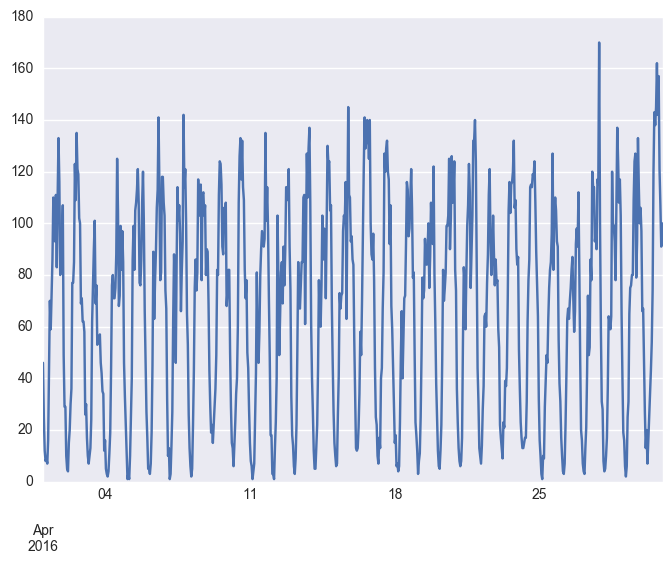

In [8]:
plt.figure(figsize=(8,6))
df_s.loc[:, 1075].plot()

Аномалия связана со снежной бурей, накрывшей Нью-Йорк 23, 24 января. В изученном на прошлой неделе 1129 регионе эта аномалия также присутствовала, поэтому можно предположить, что она имеется у всех регионов.

Стандартизуем данные по каждому региону.

In [9]:
from sklearn.preprocessing import StandardScaler

In [10]:
scaler = StandardScaler()
sc_df = pd.DataFrame(scaler.fit_transform(df_s), columns = df_s.columns, index = df_s.index)
sc_df.head()

,1075,1076,1077,1125,1126,1127,1128,1129,1130,1131,...,1630,1684,1733,1734,1783,2068,2069,2118,2119,2168
2016-04-01 00:00:00,-0.515019,-1.031047,-0.999806,-0.047065,-0.243865,0.090873,1.221386,1.180456,1.179130,0.316922,...,-0.234588,-0.924545,-0.790592,-0.311499,-0.923175,0.237511,0.515829,0.486176,0.854275,0.858703
2016-04-01 01:00:00,-1.035163,-1.163537,-1.246812,-0.583333,-1.050387,-0.414204,0.091729,0.367868,0.705762,-0.238034,...,0.569713,-0.924545,-0.263775,-1.358649,-1.181507,-0.397122,0.515829,0.355165,-0.676341,0.100493
2016-04-01 02:00:00,-1.357157,-1.416473,-1.296214,-1.247283,-1.369013,-0.989431,-0.761278,-0.298746,0.541287,-1.153711,...,0.770789,-0.924545,-1.317410,-1.378916,-1.295476,-1.237581,-1.006810,-1.465878,-1.173792,-1.551323
2016-04-01 03:00:00,-1.456232,-1.585097,-1.444418,-1.247283,-1.627897,-1.024506,-1.377979,-0.955629,0.304603,-1.195332,...,-0.234588,-0.924545,-0.790592,-1.378916,-1.303074,-1.546321,-1.260583,-1.727899,-1.173792,-1.713796
2016-04-01 04:00:00,-1.431464,-1.536918,-1.444418,-1.349429,-1.617940,-1.206895,-1.464432,-1.125932,-0.734400,-1.625423,...,0.569713,-0.849548,-0.527184,-1.358649,-1.287878,-1.529169,-1.260583,-1.675495,-1.173792,-1.713796


Теперь перейдем к кластеризации регионов.

In [11]:
from sklearn.cluster import AffinityPropagation, DBSCAN, KMeans, SpectralClustering, MiniBatchKMeans
from sklearn.cluster.hierarchical import AgglomerativeClustering
from sklearn.metrics import silhouette_score, silhouette_samples

Для удобства испльзования методов кластеризации транспонируем полученную таблицу.

In [13]:
sc_df_t = sc_df.transpose()
sc_df_t.head()

,2016-04-01 00:00:00,2016-04-01 01:00:00,2016-04-01 02:00:00,2016-04-01 03:00:00,2016-04-01 04:00:00,2016-04-01 05:00:00,2016-04-01 06:00:00,2016-04-01 07:00:00,2016-04-01 08:00:00,2016-04-01 09:00:00,...,2016-04-30 14:00:00,2016-04-30 15:00:00,2016-04-30 16:00:00,2016-04-30 17:00:00,2016-04-30 18:00:00,2016-04-30 19:00:00,2016-04-30 20:00:00,2016-04-30 21:00:00,2016-04-30 22:00:00,2016-04-30 23:00:00
1075,-0.515019,-1.035163,-1.357157,-1.456232,-1.431464,-1.481001,-1.258082,-0.589325,0.079432,-0.193025,...,1.763709,1.937091,2.358160,1.862785,2.234316,1.342640,0.995877,0.599577,0.822496,0.624345
1076,-1.031047,-1.163537,-1.416473,-1.585097,-1.536918,-1.356250,-0.778112,0.161364,0.920170,0.775636,...,2.136670,1.907824,0.884037,1.124928,0.992438,0.823814,0.811769,0.173408,-0.525176,-0.272240
1077,-0.999806,-1.246812,-1.296214,-1.444418,-1.444418,-1.296214,-0.719865,0.893913,1.783137,0.877446,...,0.860979,0.910380,0.334031,0.317564,0.531636,0.877446,0.119958,0.268162,-0.110581,-0.472858
1125,-0.047065,-0.583333,-1.247283,-1.247283,-1.349429,-1.272820,-0.685479,0.208300,0.872250,0.310446,...,0.565812,0.565812,0.157227,0.719031,1.076543,0.821177,0.974397,1.178689,0.795641,0.438129
1126,-0.243865,-1.050387,-1.369013,-1.627897,-1.617940,-1.319228,-0.801461,-0.452963,0.413301,0.283859,...,0.931068,0.911154,0.682142,1.359222,1.428922,1.488664,0.941026,1.219823,0.214160,0.881283


Попробуем метод k-средних, будем оценивать оптимальное число соседей по коэффициентусилуэта. Так в задании сказано, что число класстеров не должно быть больши, то ограничемся сверху 10 кластерами.

In [33]:
bst_score = -2
bst_num = 2
scores_list = []
for n_clusters in range(2, 11):
    kmn_clus = KMeans(n_clusters=n_clusters, random_state=20)
    res = kmn_clus.fit_predict(sc_df_t)
    score = silhouette_score(sc_df_t, res)
    scores_list.append(score)
    if score > bst_score:
        bst_num = n_clusters
        bst_score = score
print bst_score, bst_num

0.260467612395 3


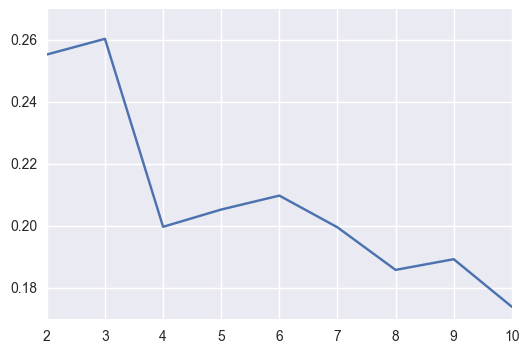

In [34]:
plt.plot(range(2,11), scores_list)

Лучший результат был получен при k = 3, что нас не устраивает. Посмотрим на силует при разных k. Код взят с сайта scikit-learn.

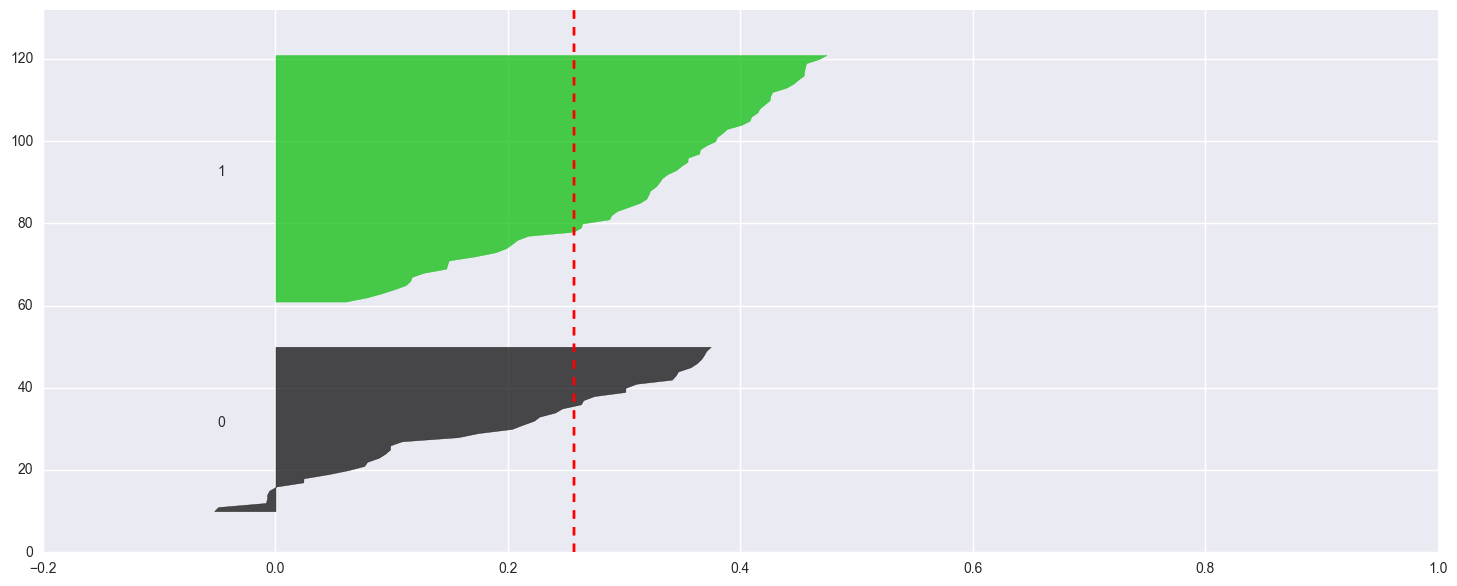

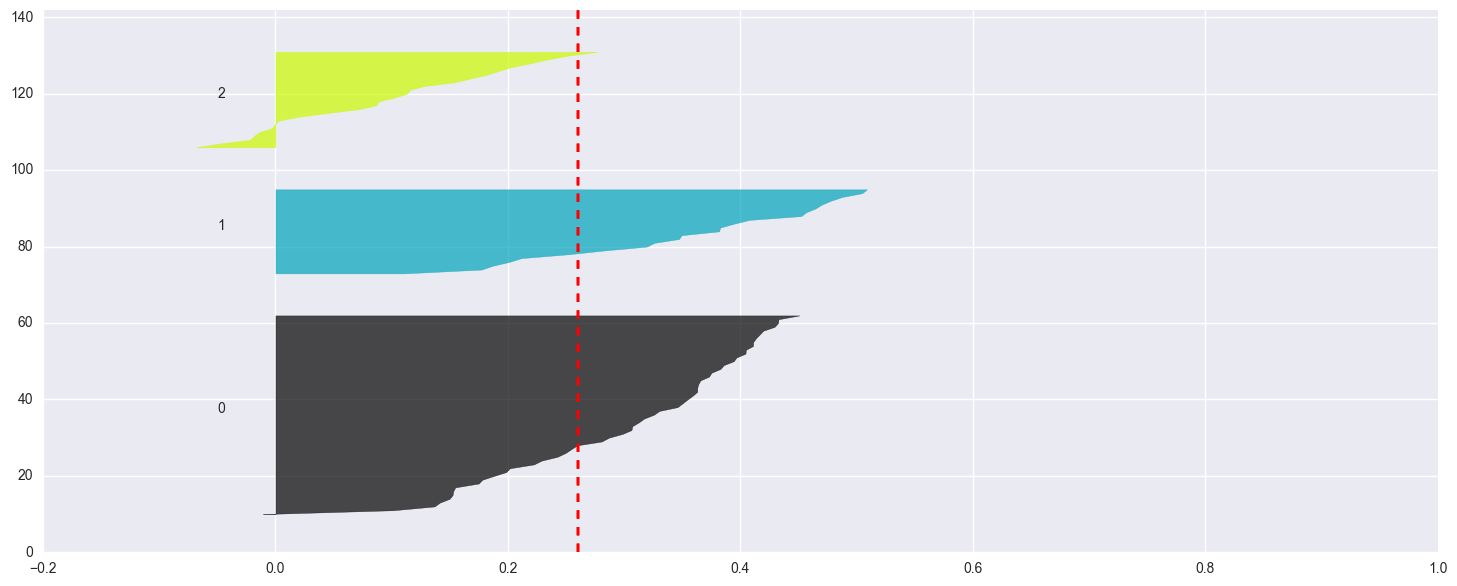

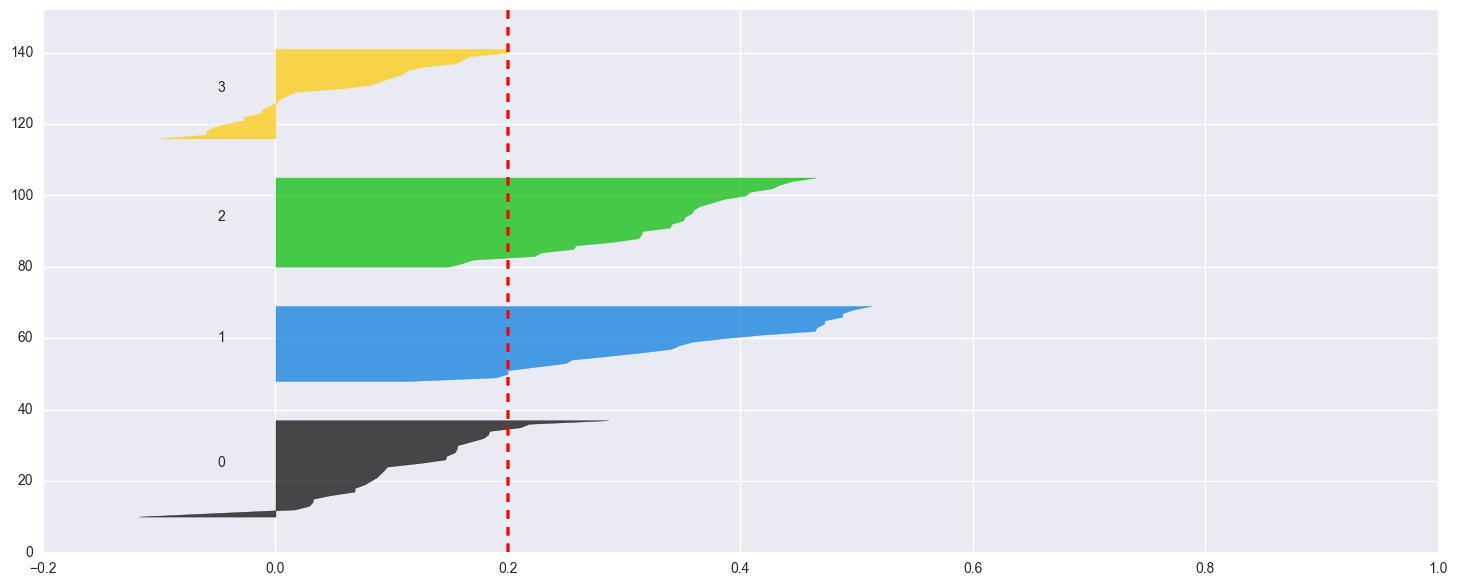

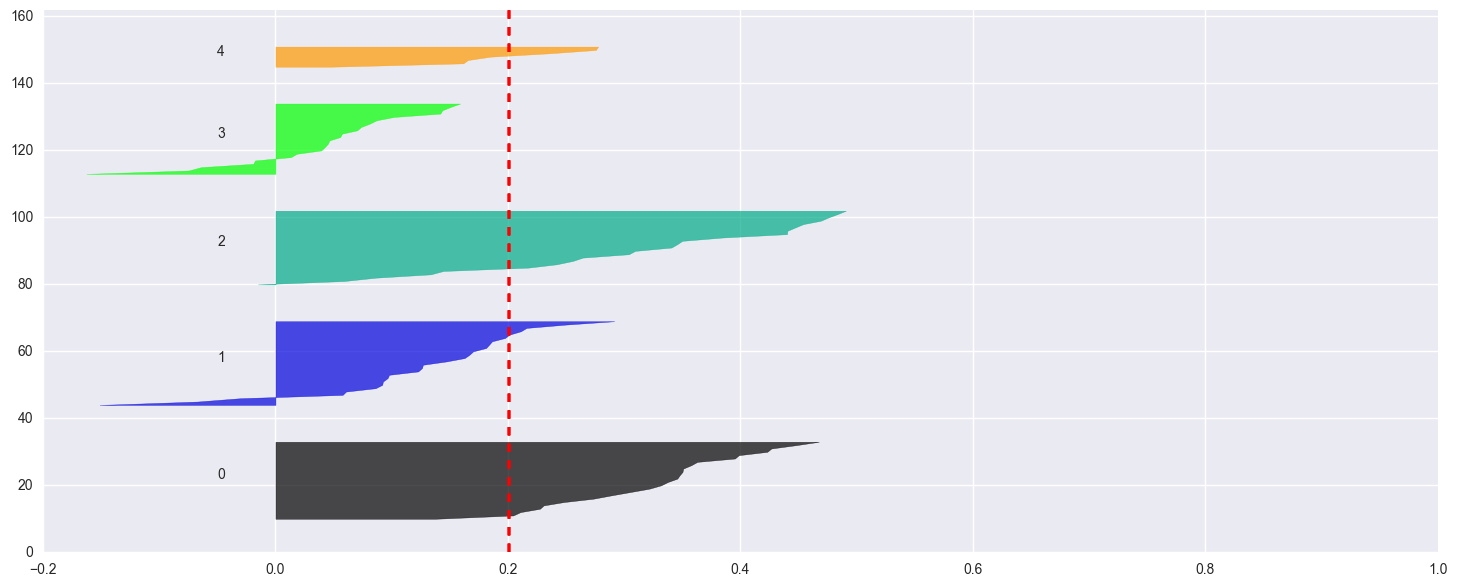

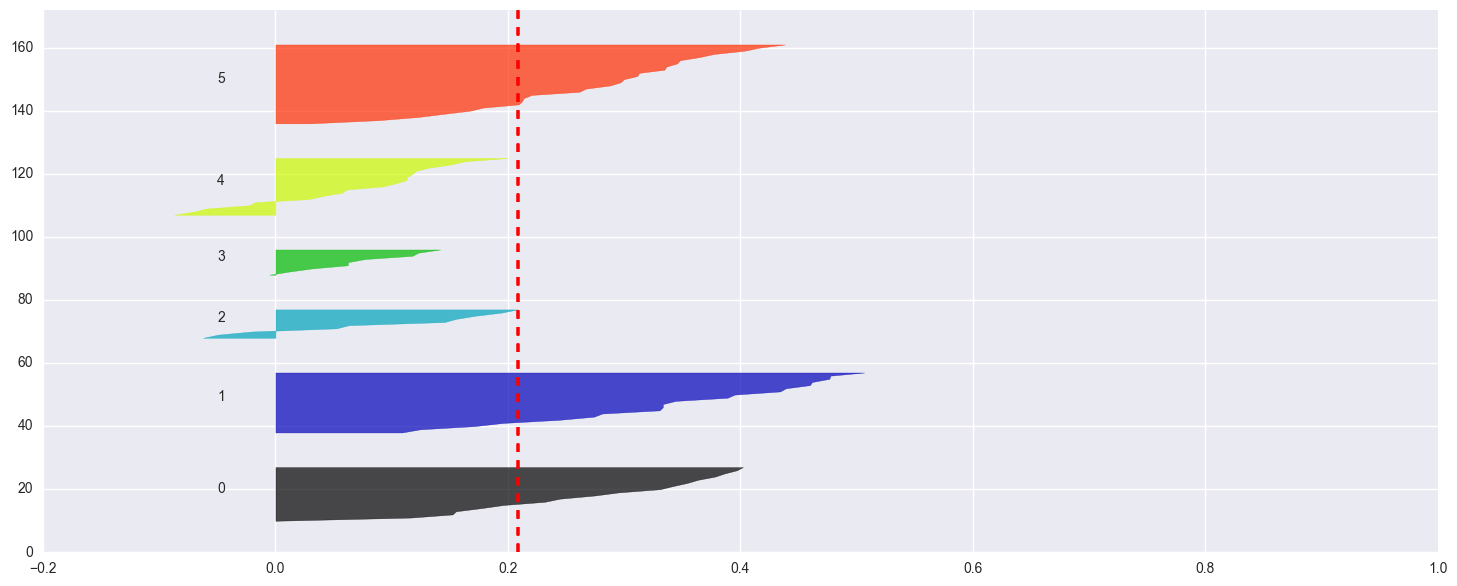

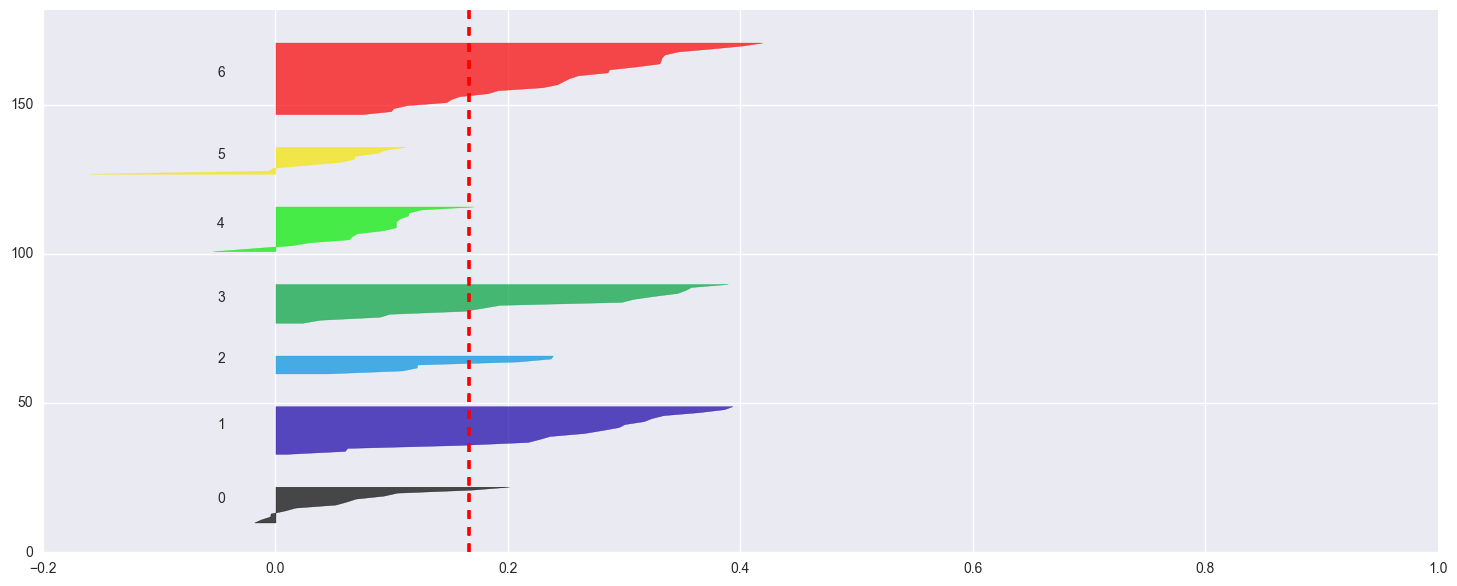

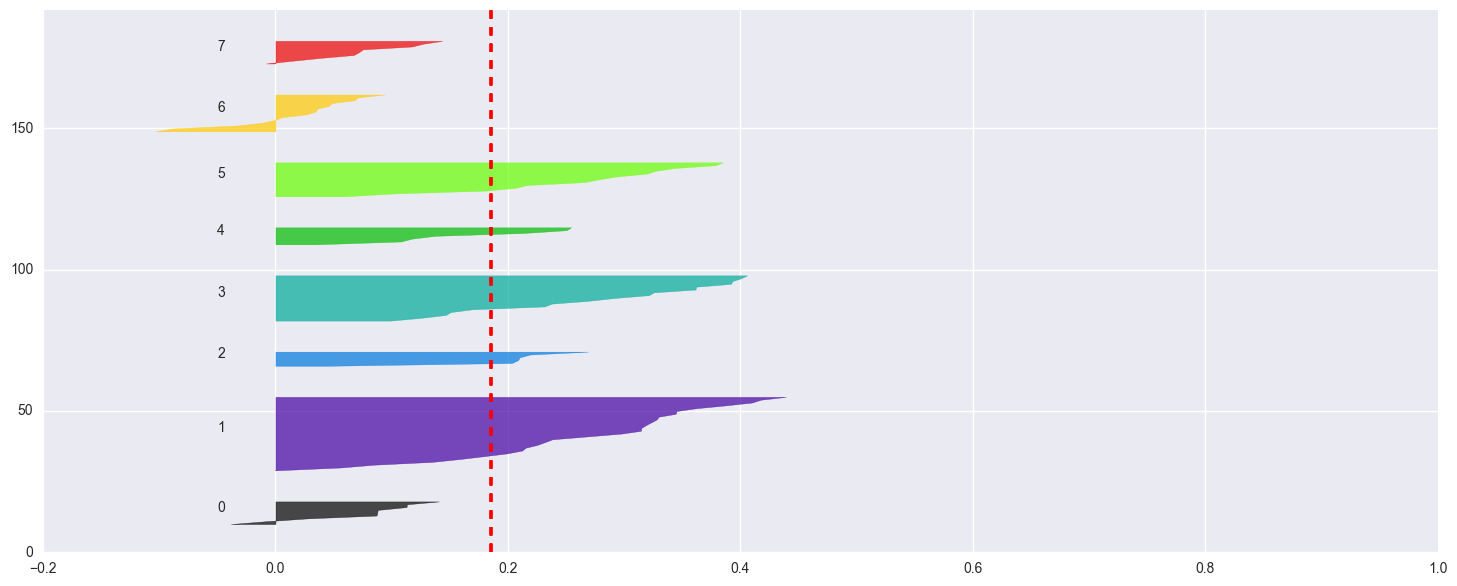

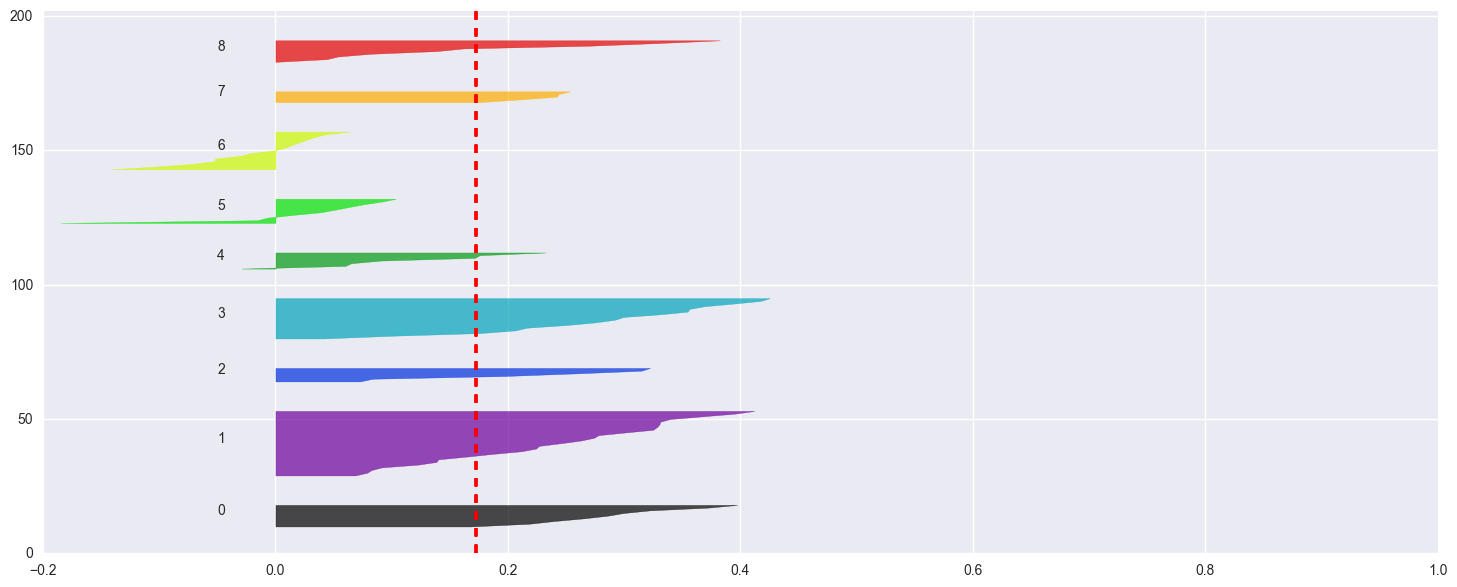

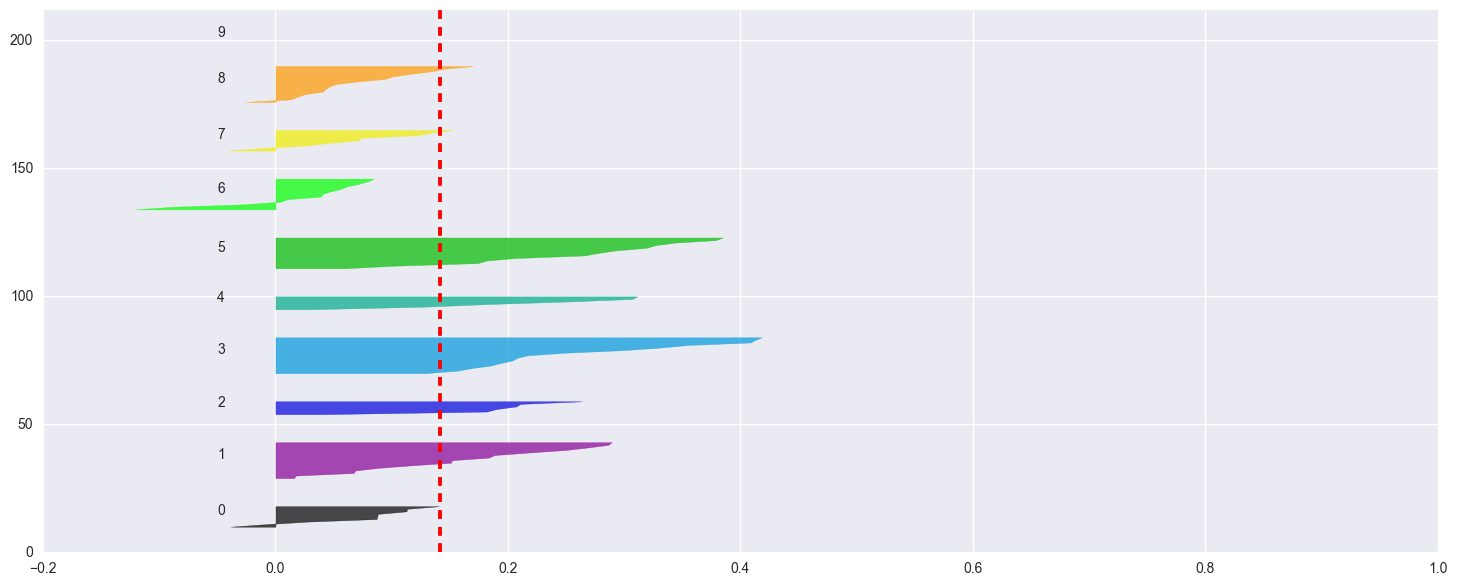

In [37]:
def plot_silhouette(clus, data, n_clusters):
    res = clus.fit_predict(data)
    sil = silhouette_samples(data, res)
    silhouette_avg = silhouette_score(data, res)
    y_lower = 10

    fig, ax = plt.subplots()
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax.set_xlim([-0.2, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax.set_ylim([0, len(data) + (n_clusters + 1) * 10])

    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sil[res == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.spectral(float(i) / n_clusters)
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

        ax.axvline(x=silhouette_avg, color="red", linestyle="--")
for n_clusters in range(2, 11):
    plot_silhouette(KMeans(n_clusters=n_clusters, random_state=140), sc_df_t, n_clusters)

Видим, что разброс по кластерам для разных значений k очень большой. Оптимальынм выглядит разбиение на 8 кластеров. Посмотрим на количество элементов в каждом кластере при таком разбиении.

In [345]:
kmn_clus = KMeans(n_clusters=8, random_state=20)
res = kmn_clus.fit_predict(sc_df_t)
np.unique(res, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 array([ 5,  6, 17, 19, 10, 27,  5, 13], dtype=int64))

Попробуем воспользоваться агломеративной кластеризацией, возможно она проявит себя лучше.

In [346]:
bst_score = -2
bst_num = 2
scores_list = []
for n_clusters in range(2, 11):
    agg_clus = AgglomerativeClustering(n_clusters=n_clusters)
    res = agg_clus.fit_predict(sc_df_t)
    score = silhouette_score(sc_df_t, res)
    scores_list.append(score)
    if score > bst_score:
        bst_num = n_clusters
        bst_score = score
print bst_score, bst_num

0.242511527129 3


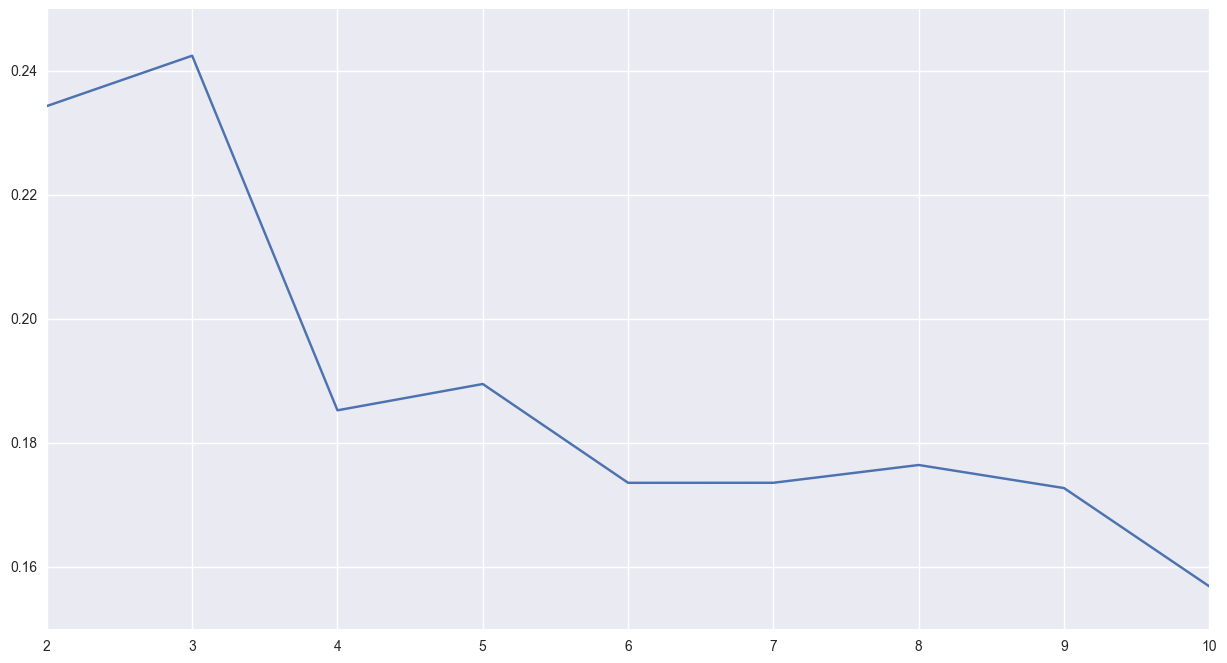

In [347]:
plt.plot(range(2,11), scores_list)

Здесь мы получили уже более интересный график.

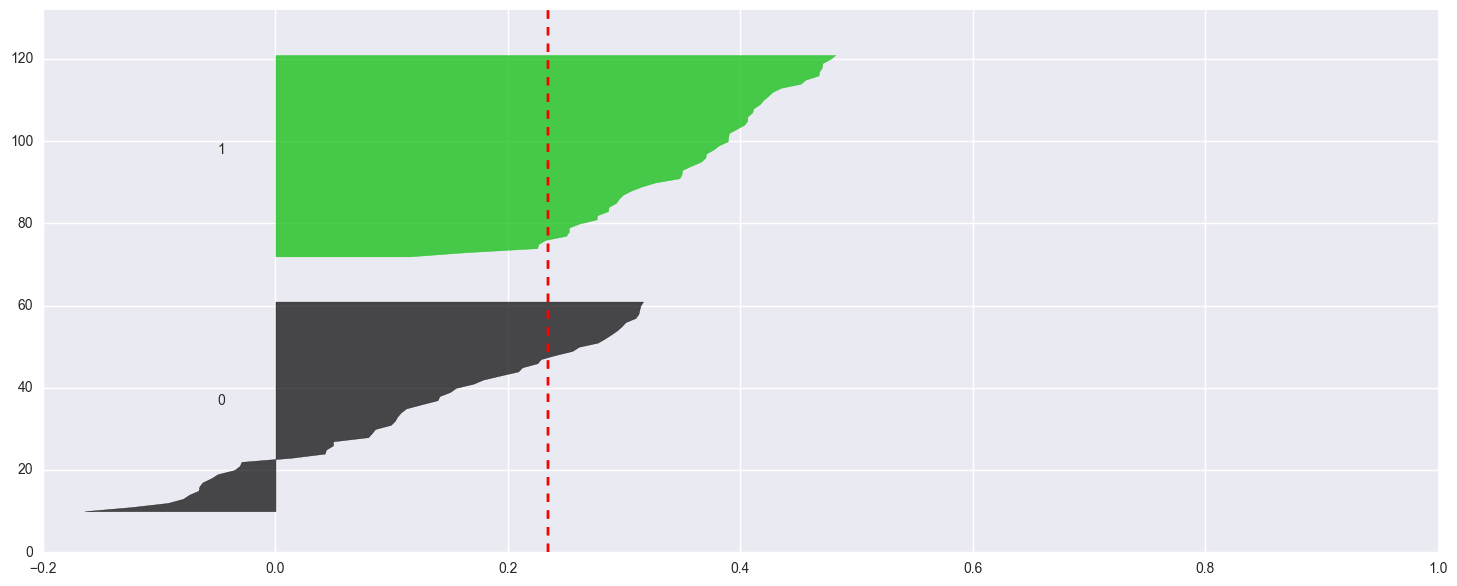

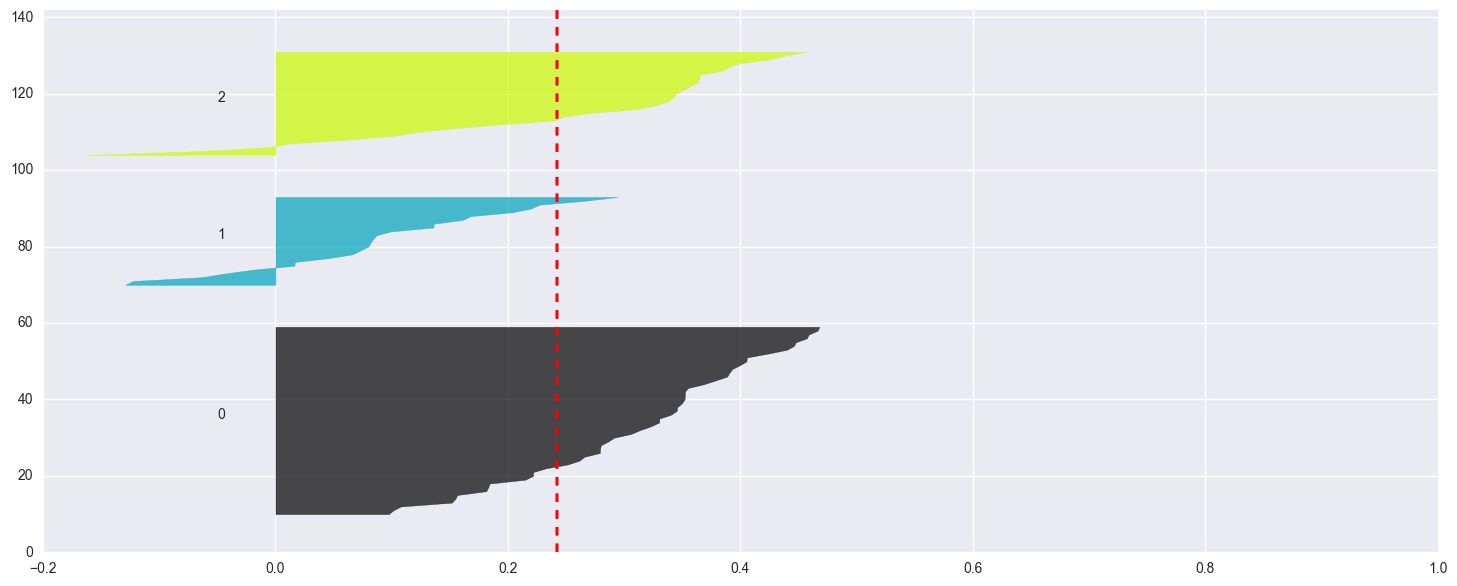

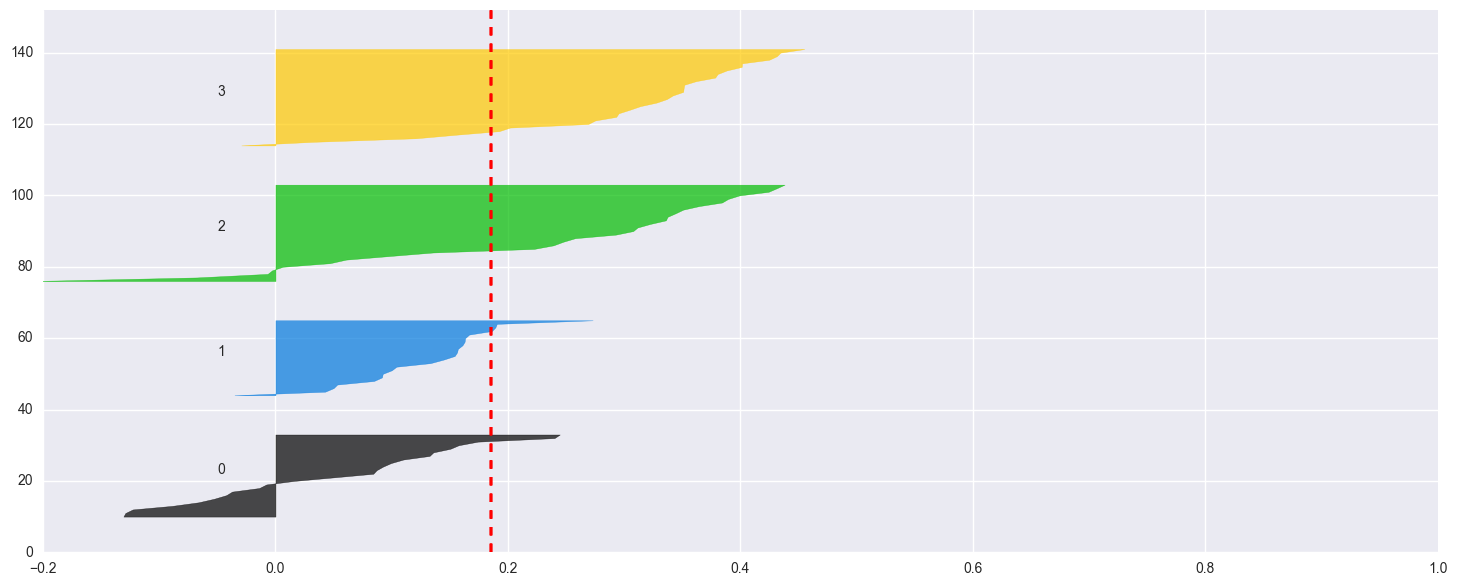

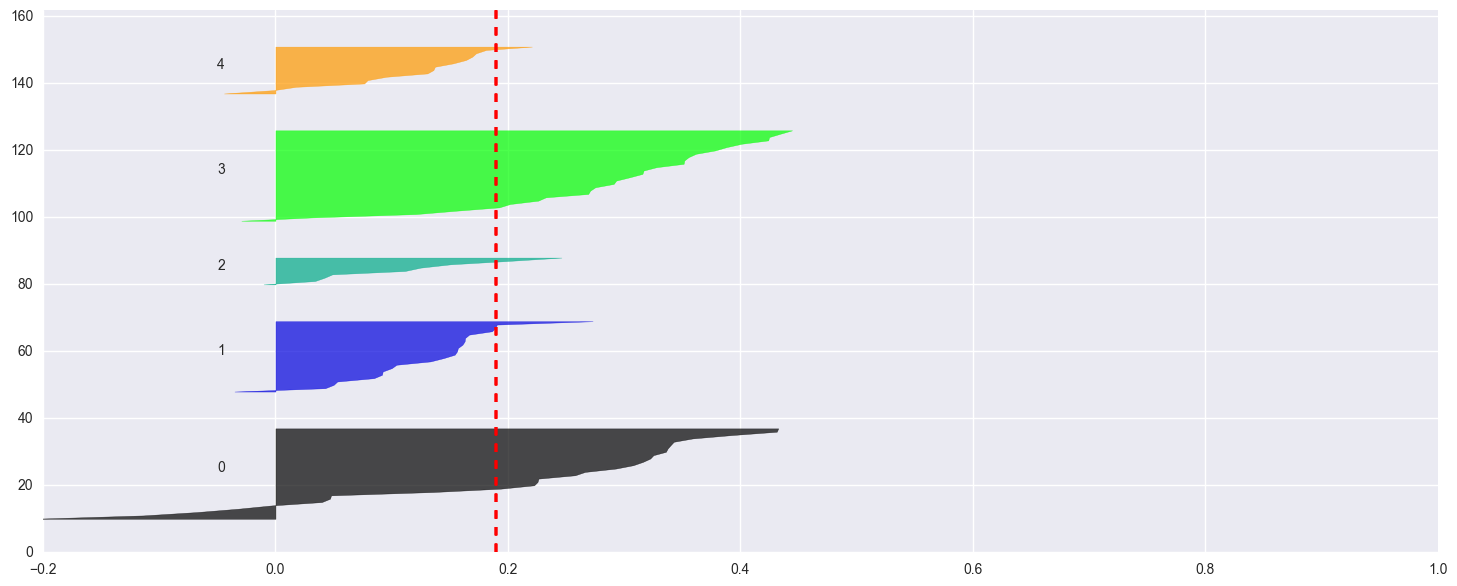

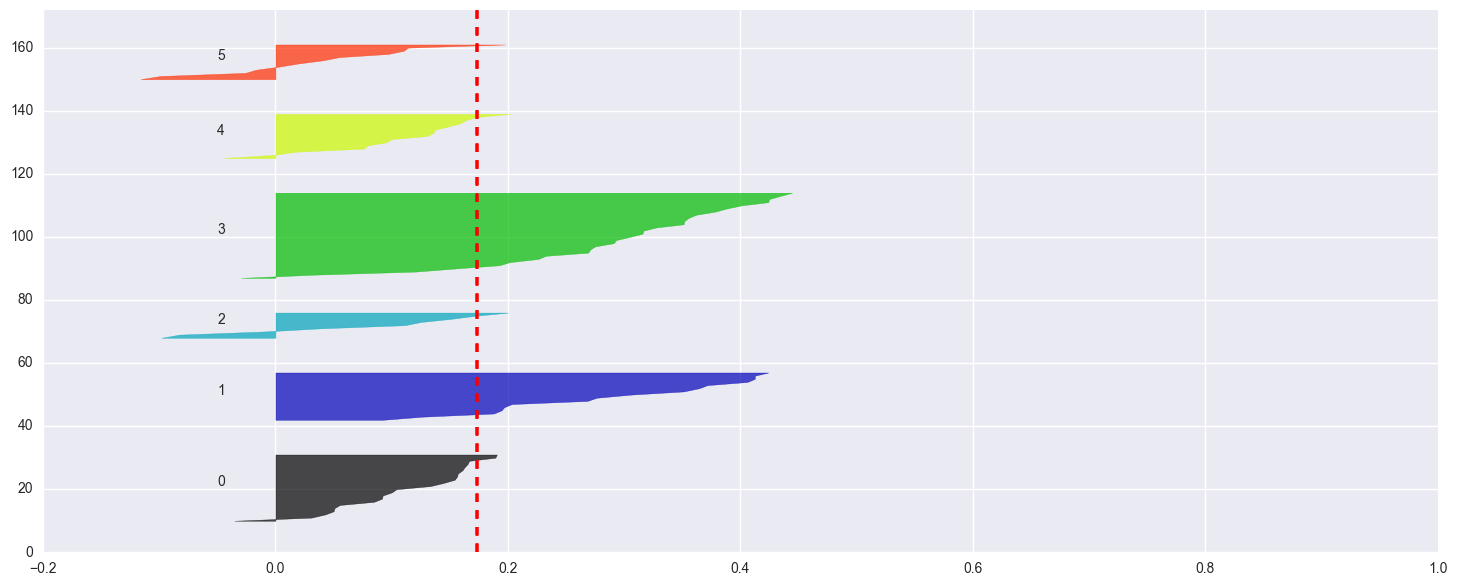

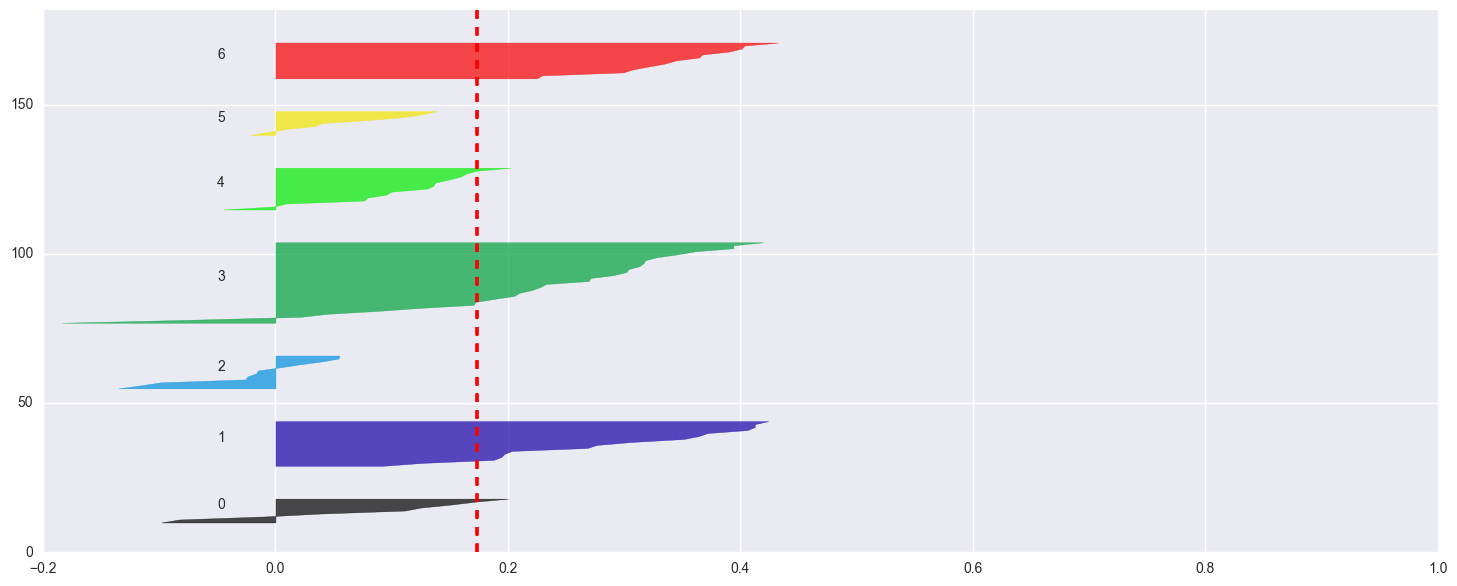

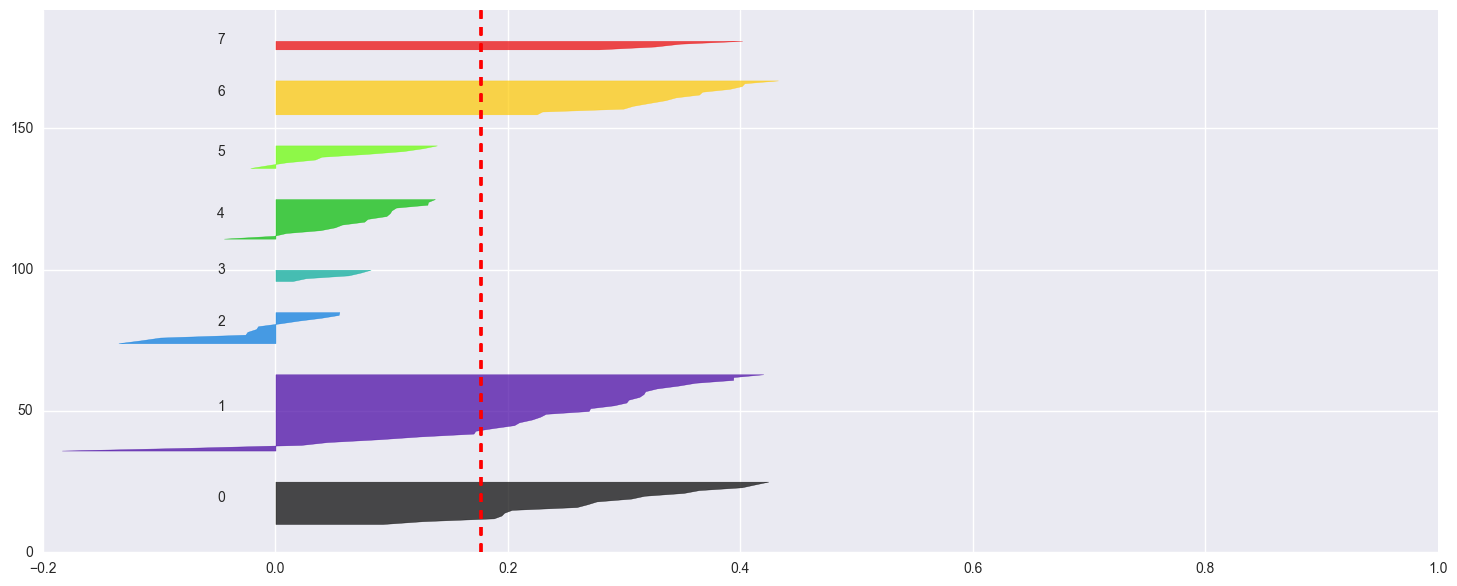

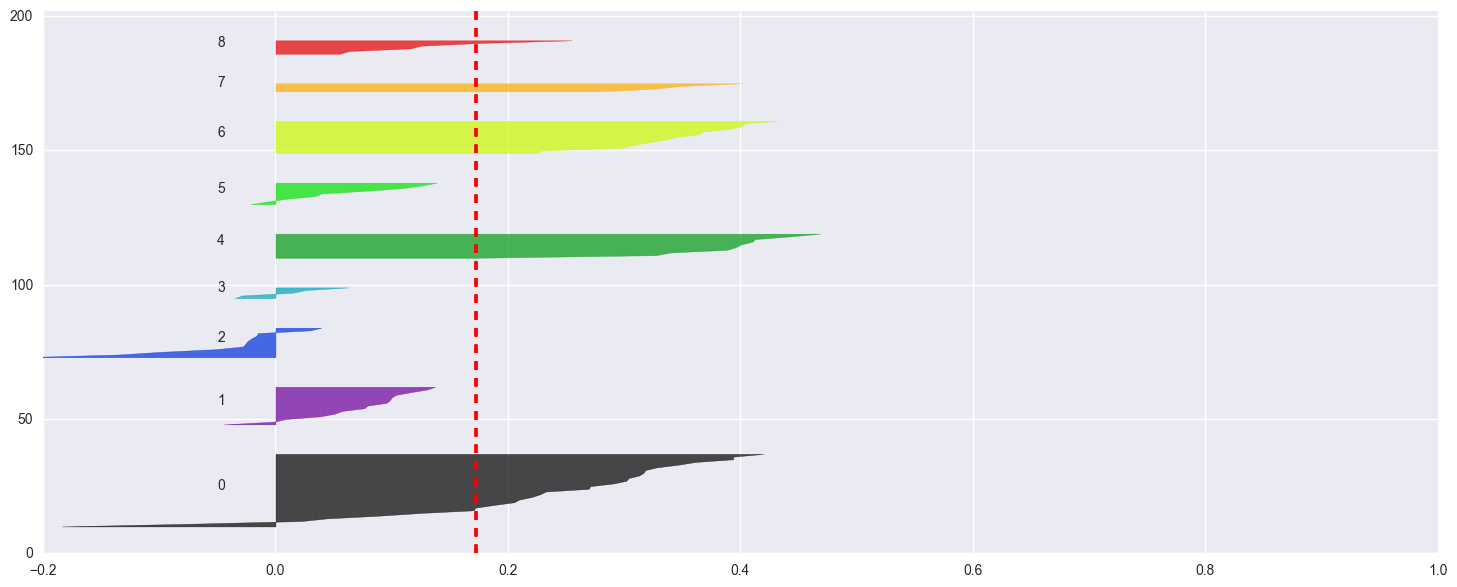

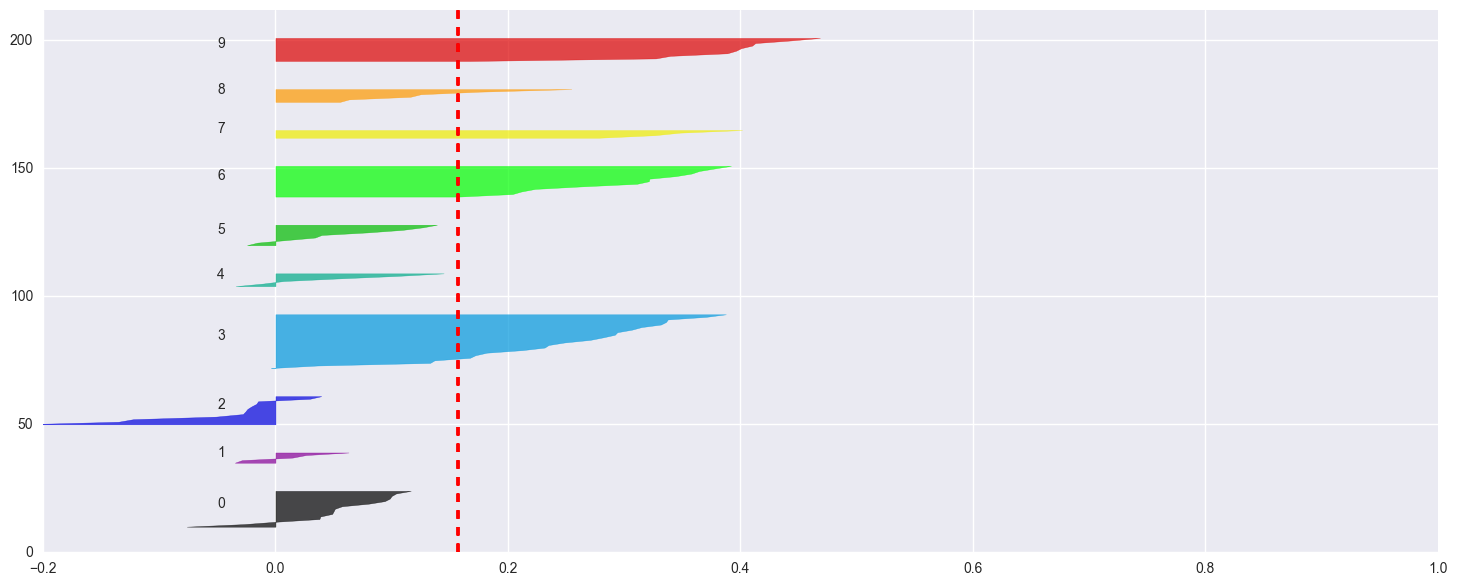

In [348]:
for n_clusters in range(2, 11):
    plot_silhouette(AgglomerativeClustering(n_clusters=n_clusters), sc_df_t, n_clusters)

Здесь наблюдается схожая ситуация.

In [349]:
agg_clus = AgglomerativeClustering(n_clusters=10)
res = agg_clus.fit_predict(sc_df_t)
np.unique(res, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64),
 array([15,  5, 12, 22,  6,  9, 13,  4,  6, 10], dtype=int64))

Наблюдается схожая картина. Попробуем MiniBatchKMeans метод.

0.25448901779 2


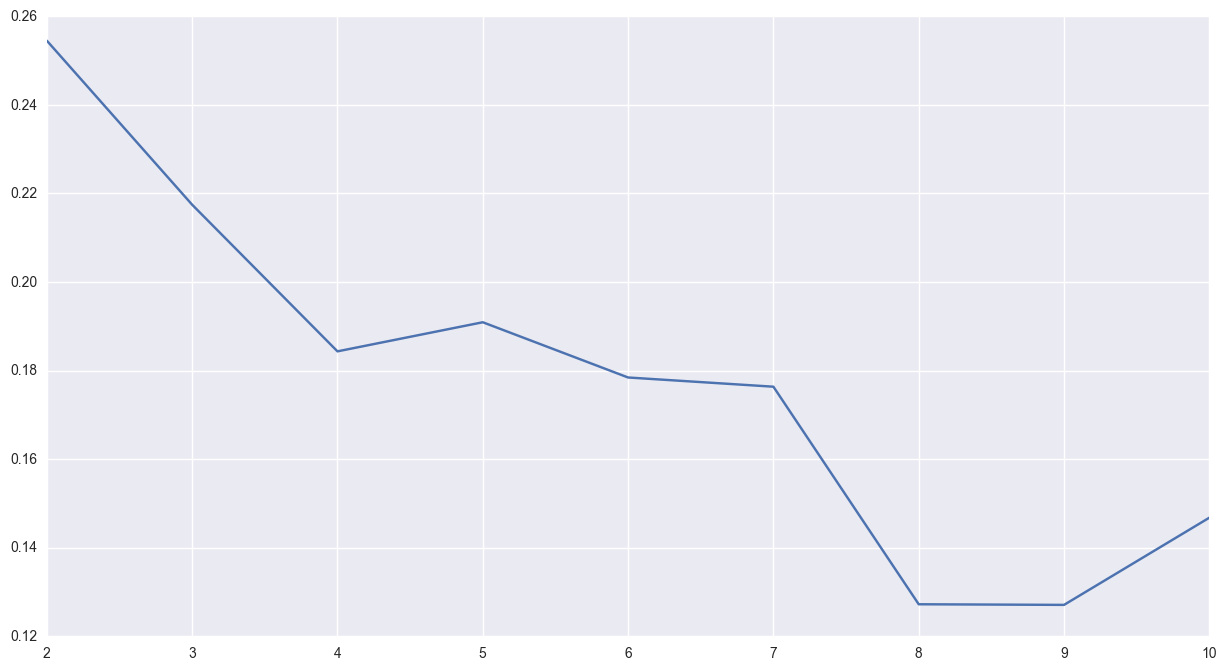

In [350]:
bst_score = -2
bst_num = 2
scores_list = []
for n_clusters in range(2, 11):
    mnk_clus = MiniBatchKMeans(n_clusters=n_clusters, random_state=10)
    res = mnk_clus.fit_predict(sc_df_t)
    score = silhouette_score(sc_df_t, res)
    scores_list.append(score)
    if score > bst_score:
        bst_num = n_clusters
        bst_score = score
print bst_score, bst_num
plt.plot(range(2,11), scores_list)

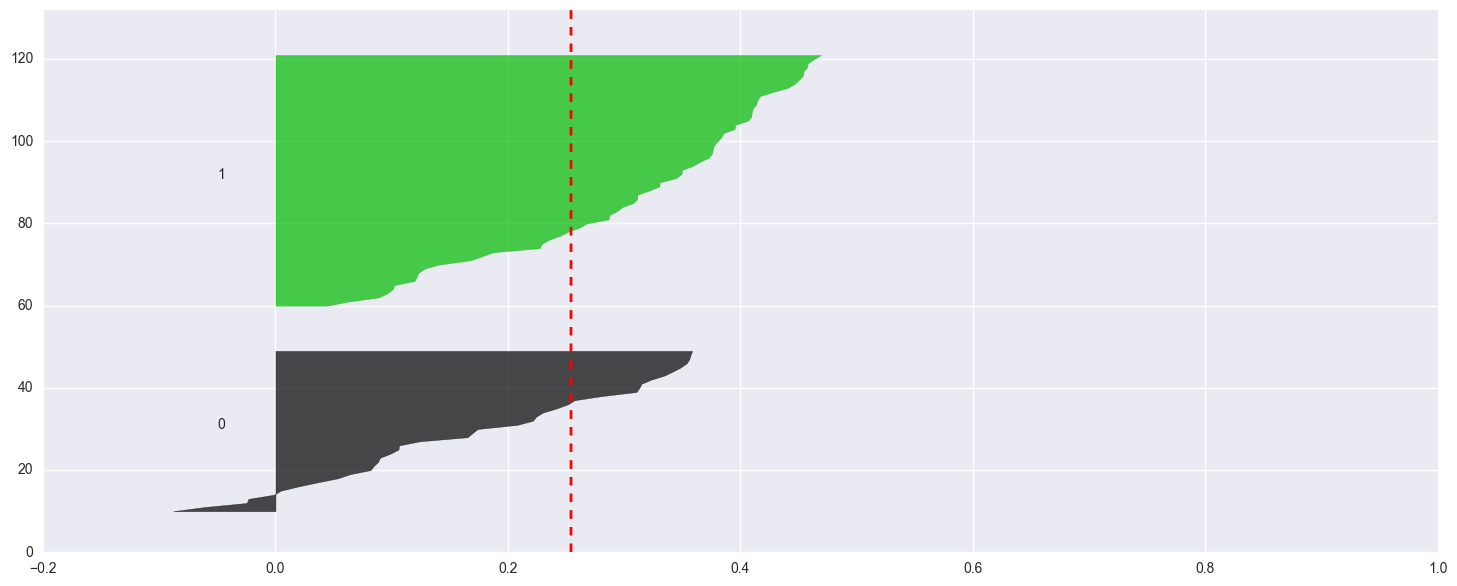

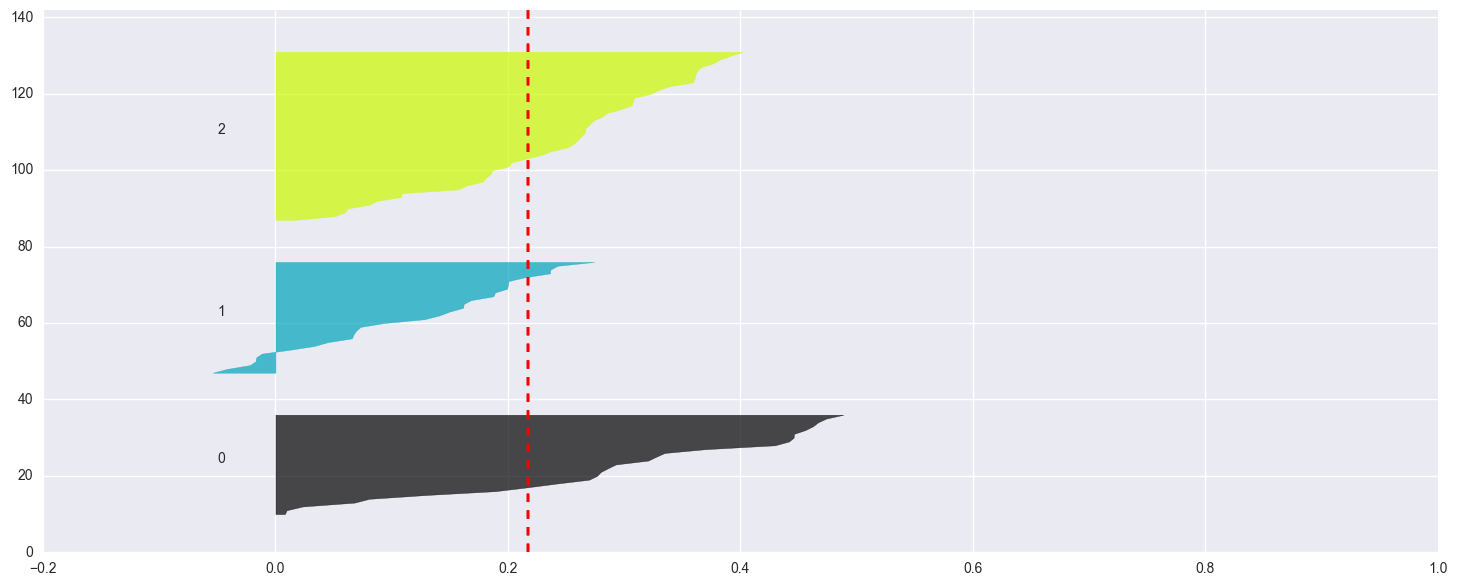

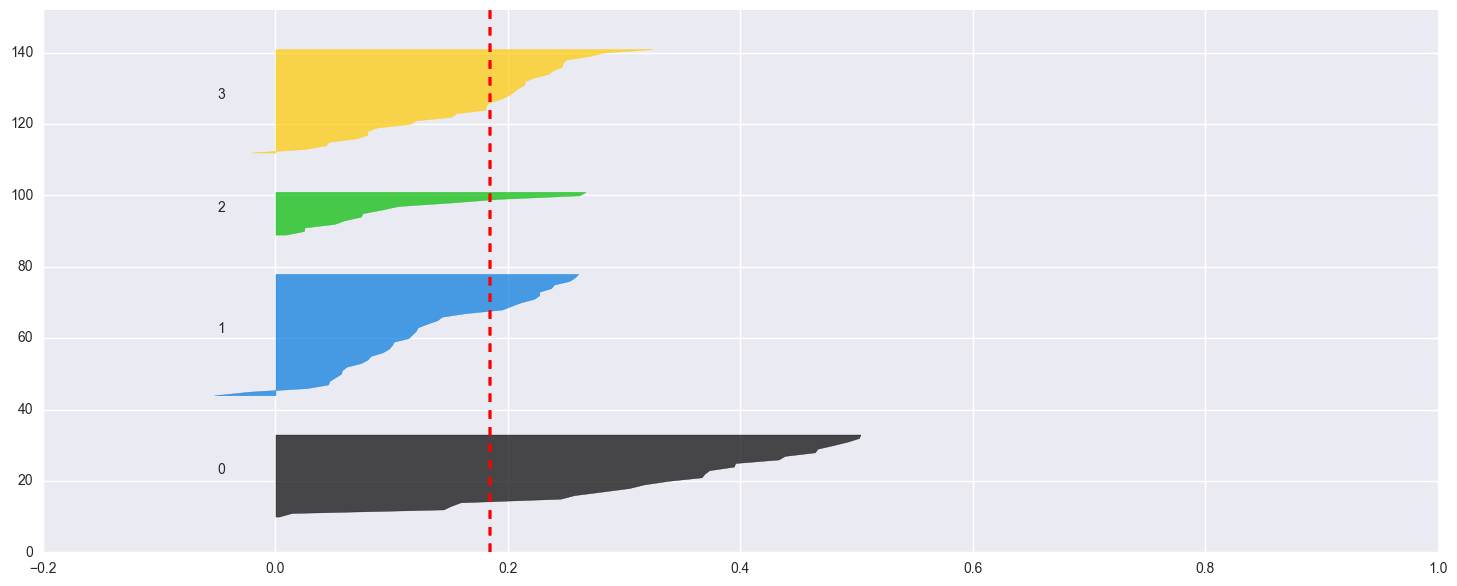

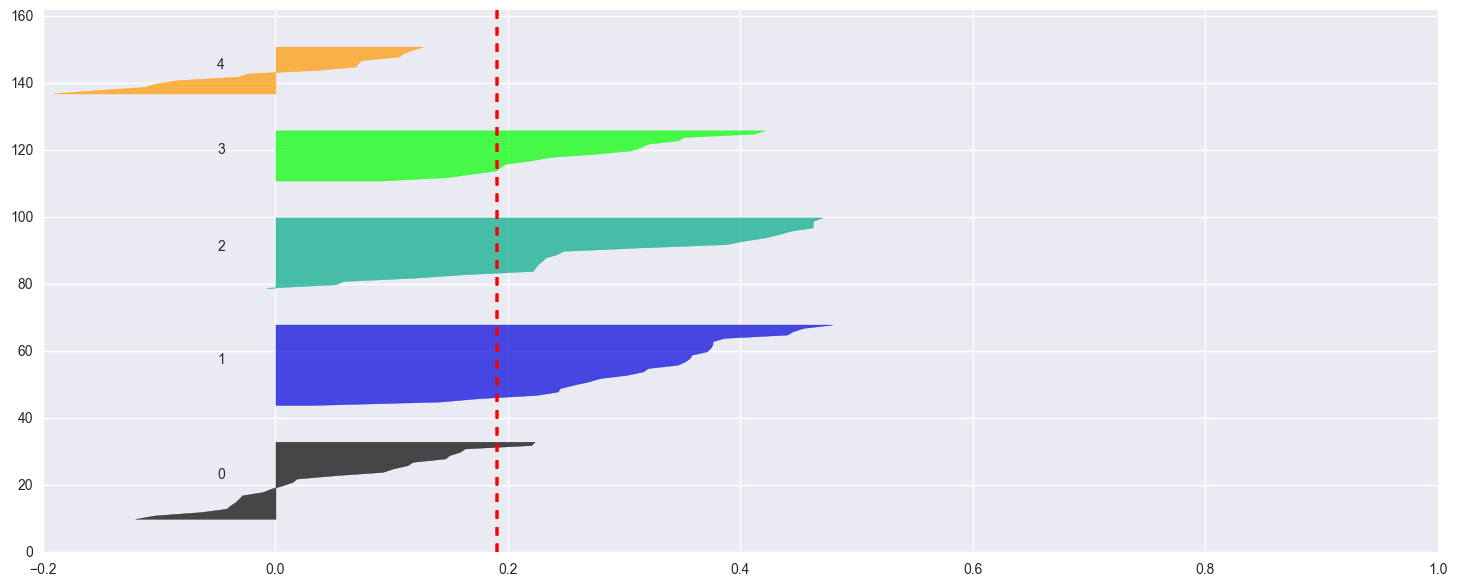

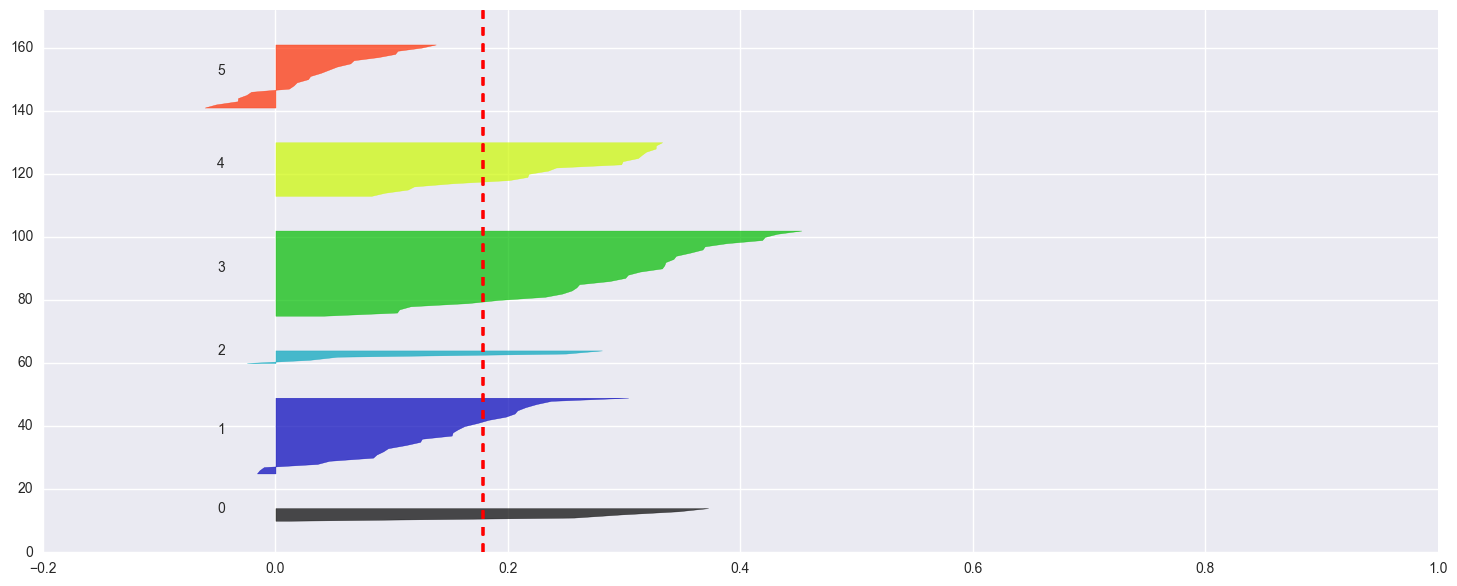

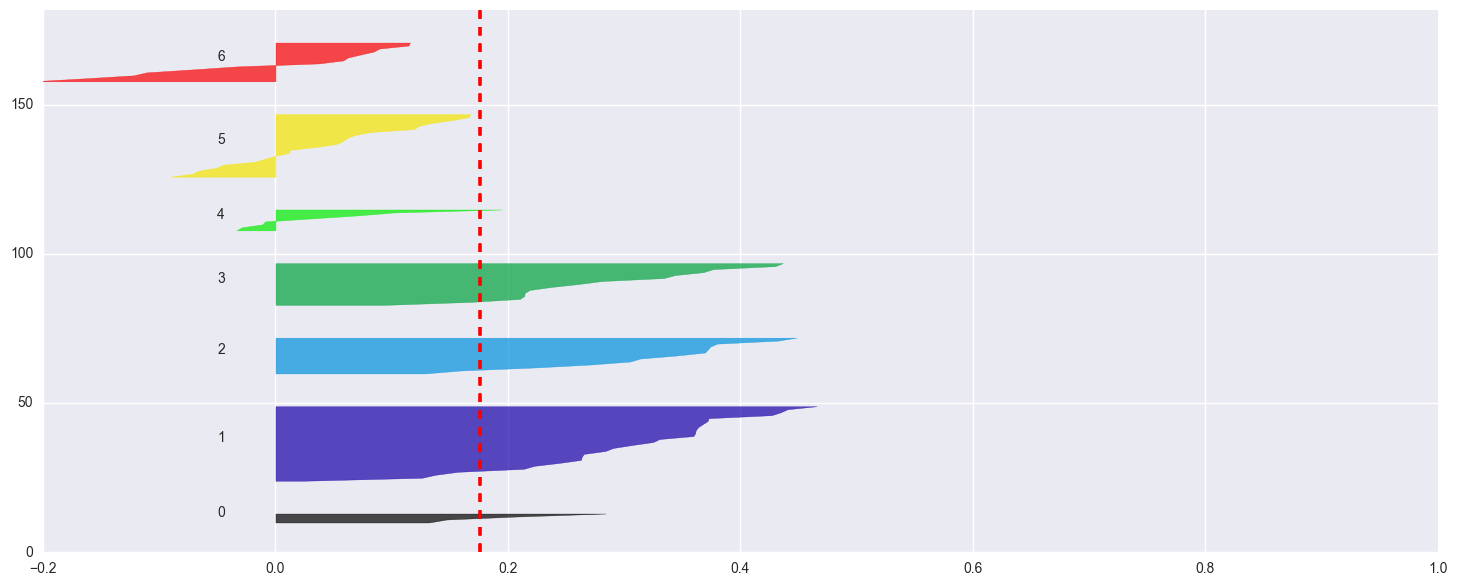

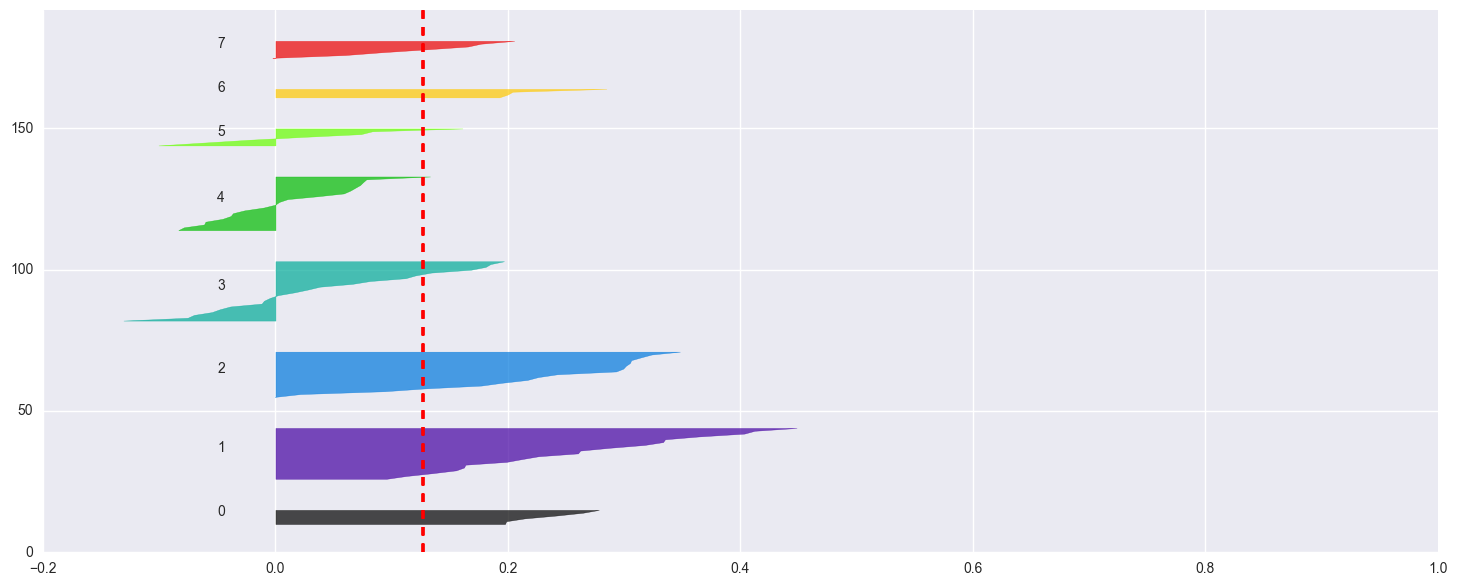

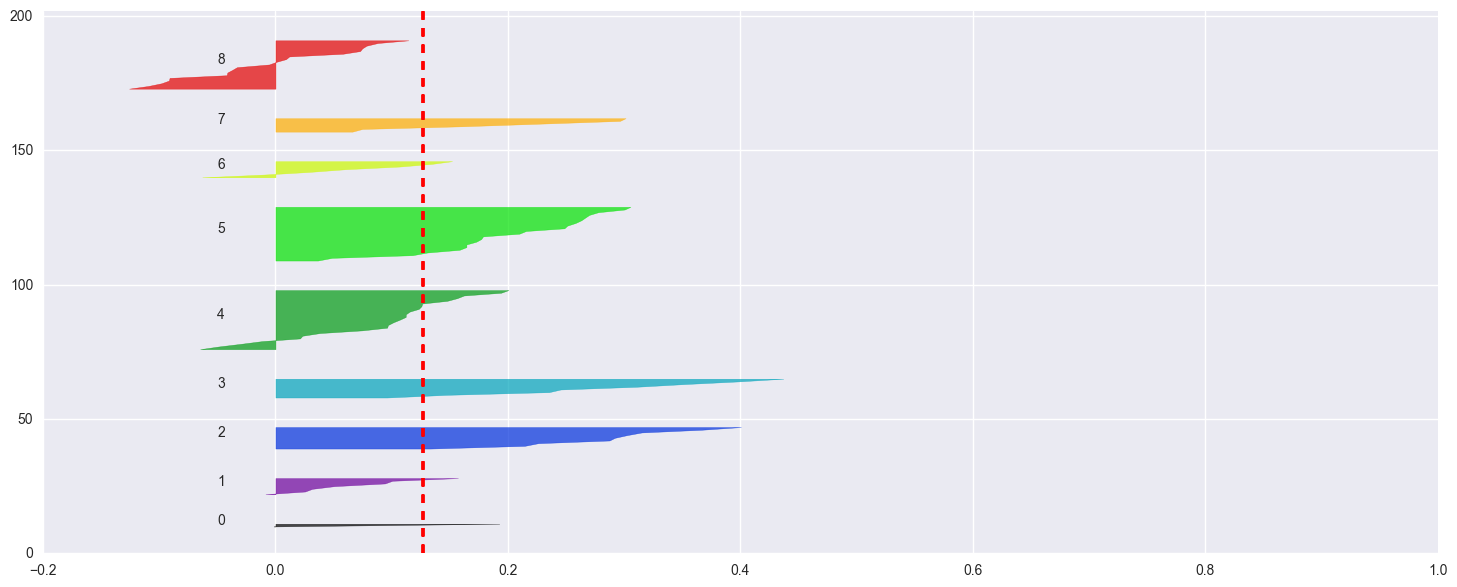

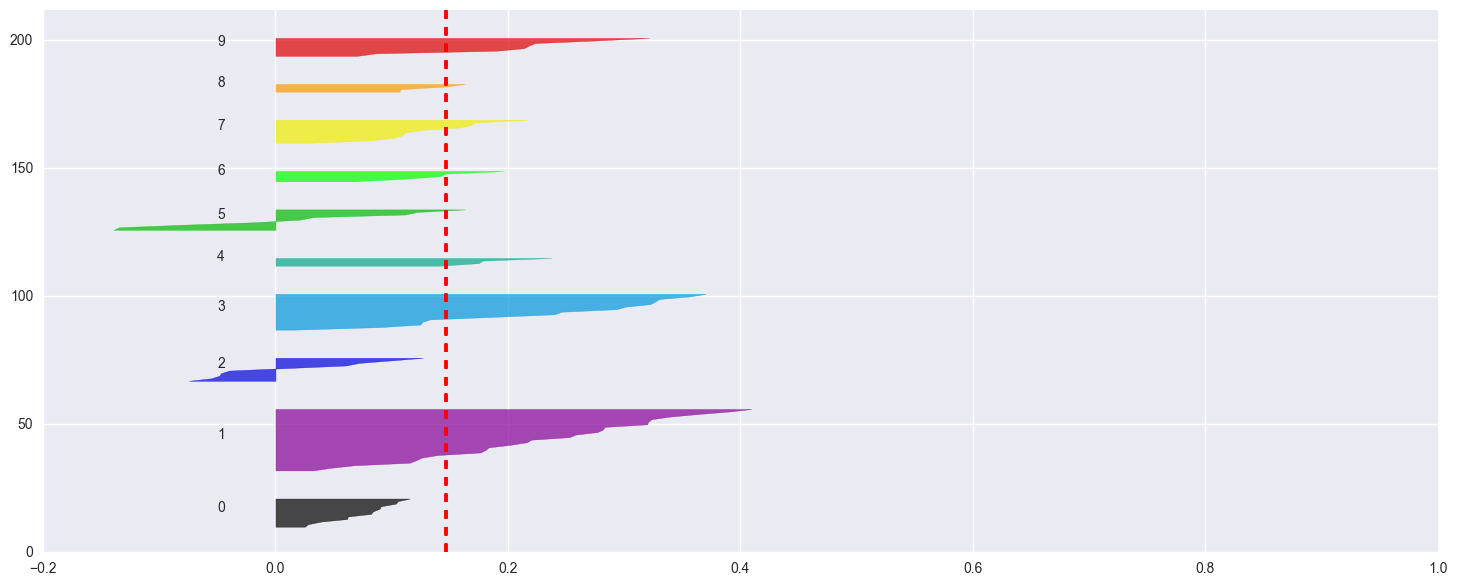

In [351]:
for n_clusters in range(2, 11):
    plot_silhouette(MiniBatchKMeans(n_clusters=n_clusters, random_state=10), sc_df_t, n_clusters)

Видим, что результаты, полученные при использовании разных методов различаются не столь сильно.

Были применены и другие методы: SpectralClustering, DBSCAN, но результаты получились схожие или даже хуже, поэтому здесь не приводятся.
Количество кластеров будем подбирать визуально, далее не будет описываться сам подбор, а будут показаны результаты.

Для кластеризации был выбран AgglomerativeClustering с разбиением на 7 класетров. Так кластеры получаются более или менее равномерными (это видно и по силуэтами), а при увеличении числа кластеров появляются кластеры состоящие из 1 - 4 регионов, что уменьшает смысл кластеризации. 

In [15]:
agg_cls = AgglomerativeClustering(n_clusters=7)
res = agg_cls.fit_predict(sc_df_t)
np.unique(res, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6], dtype=int64),
 array([ 9, 18, 10, 28, 13, 16,  8], dtype=int64))

Также был проведен визуальный анализ полученных кластеров, который показал, что кластеризация была удовлетворительной. Графики стандартизированных рядов получились схожими. Далее, чтобы не усложнять чтение ноутбука, приводится только один из кластеров.

In [16]:
sc_df_t[res == 0]

,2016-04-01 00:00:00,2016-04-01 01:00:00,2016-04-01 02:00:00,2016-04-01 03:00:00,2016-04-01 04:00:00,2016-04-01 05:00:00,2016-04-01 06:00:00,2016-04-01 07:00:00,2016-04-01 08:00:00,2016-04-01 09:00:00,...,2016-04-30 14:00:00,2016-04-30 15:00:00,2016-04-30 16:00:00,2016-04-30 17:00:00,2016-04-30 18:00:00,2016-04-30 19:00:00,2016-04-30 20:00:00,2016-04-30 21:00:00,2016-04-30 22:00:00,2016-04-30 23:00:00
1431,-0.624803,-0.173229,-0.986063,-1.166693,-0.805433,0.097716,0.007401,-0.353859,0.820235,0.097716,...,0.007401,0.458975,-0.444174,0.097716,0.278345,-0.082914,-0.444174,0.729920,-0.173229,0.729920
1480,-0.733838,-0.487112,-0.610475,-0.857201,0.129702,-0.117023,1.239969,1.486695,2.473598,1.363332,...,0.623154,-0.363749,-0.487112,0.253065,-0.240386,0.006339,-0.117023,-0.117023,0.006339,0.376428
1482,0.301154,-0.219448,-0.349599,-0.870201,2.123261,0.040853,0.691605,1.212208,1.082057,1.212208,...,0.040853,-0.089298,-0.870201,-0.349599,0.040853,-0.349599,-0.479749,0.691605,0.301154,3.554917
1483,-0.524045,-0.782478,-0.524045,-0.653261,-0.007179,0.380471,1.672636,3.869316,3.481666,2.189502,...,-0.007179,-0.007179,-0.007179,-0.394828,-0.265612,-0.265612,-0.265612,-0.524045,-0.524045,0.768120
1530,-0.392841,-0.476055,-0.476055,-0.642484,0.106445,0.356088,0.772159,2.519659,2.519659,0.272873,...,-0.309626,-0.226412,-0.143198,-0.059984,-0.309626,-0.559269,-0.309626,-0.559269,-0.559269,-0.476055
1532,0.640347,-0.000222,1.441059,0.800490,1.120774,-0.000222,0.960632,0.480205,-0.800935,-0.640792,...,-0.800935,0.640347,-0.160365,0.480205,0.159920,-0.480650,0.320062,-0.320507,-0.320507,0.480205
1533,0.984920,0.155375,0.392388,0.273881,0.036869,-0.437157,0.510894,1.103426,0.392388,-0.318650,...,-0.792676,0.273881,-0.555663,-0.555663,-0.792676,-0.318650,-0.081638,-0.081638,0.036869,1.103426
1580,-0.594079,-0.271137,-0.594079,-0.594079,0.051805,0.213276,2.473871,2.150929,0.051805,0.051805,...,-0.755550,-0.271137,-0.271137,-0.594079,-0.432608,-0.432608,-0.271137,-0.594079,-0.594079,-0.432608
1630,-0.234588,0.569713,0.770789,-0.234588,0.569713,-0.033513,0.167563,-0.234588,0.770789,-0.837814,...,-0.837814,-0.837814,-1.038889,-0.435663,-0.435663,-0.837814,-0.636738,-0.636738,-0.837814,-0.234588


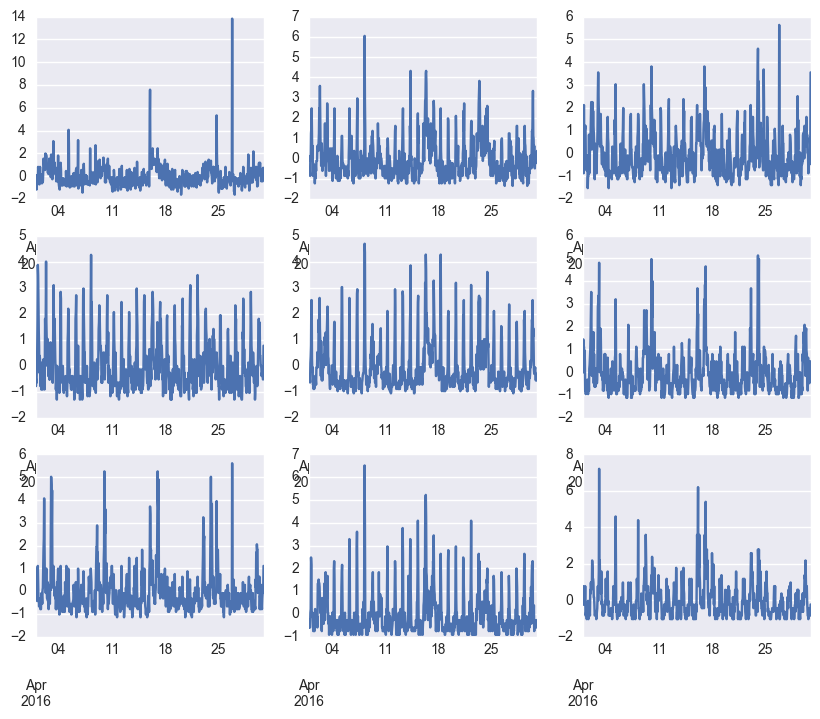

In [17]:
# 0 cluster
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(10,8))
for i, j in enumerate(sc_df_t.index[res == 0]):
    sc_df[j].plot(ax=ax[i/3, i%3])

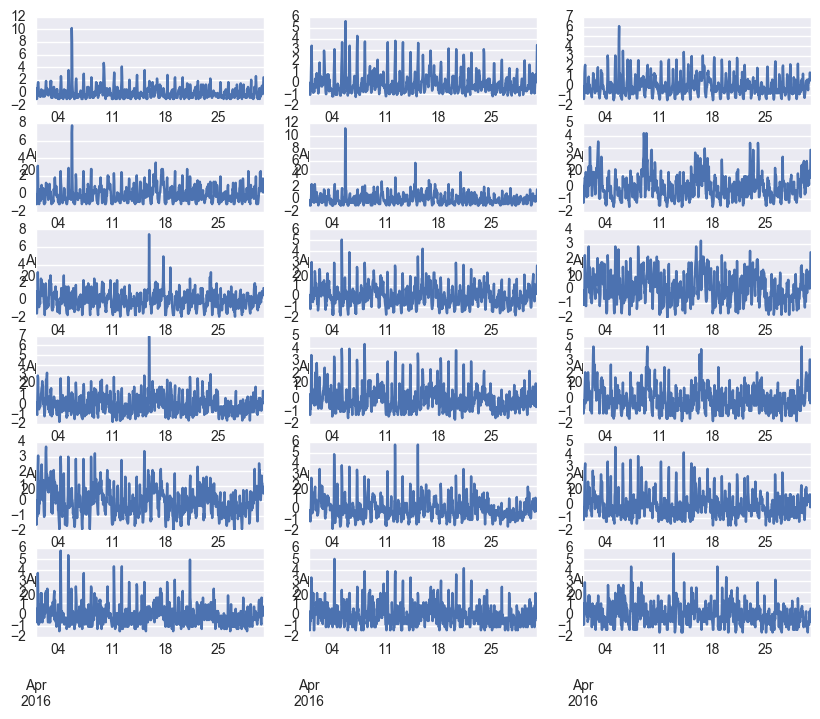

In [18]:
fig, ax = plt.subplots(nrows=6, ncols=3, figsize=(10,8))
for i, j in enumerate(sc_df_t.index[res == 1]):
    sc_df[j].plot(ax=ax[i/3, i%3])

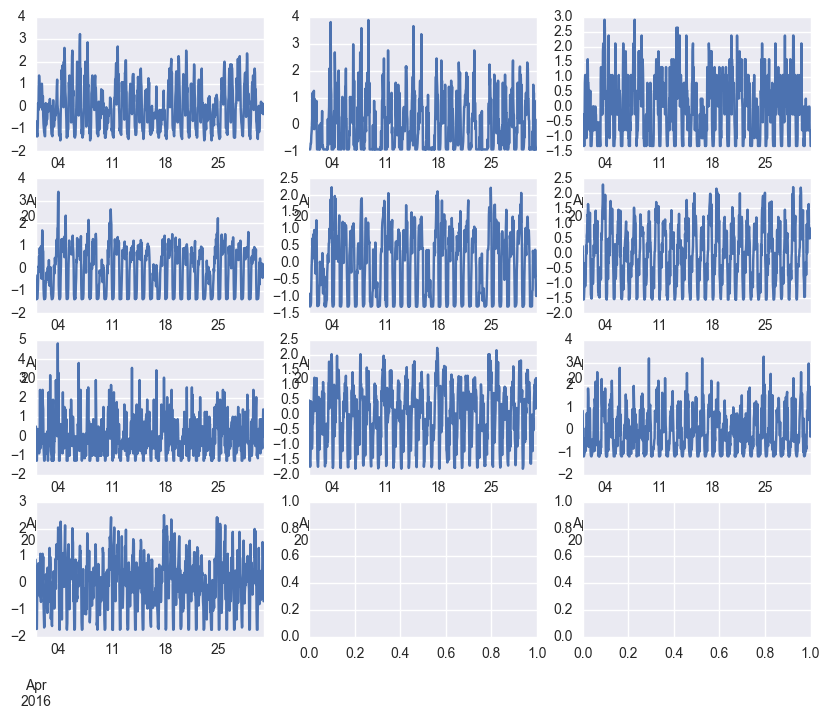

In [19]:
fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(10,8))
for i, j in enumerate(sc_df_t.index[res == 2]):
    sc_df[j].plot(ax=ax[i/3, i%3])

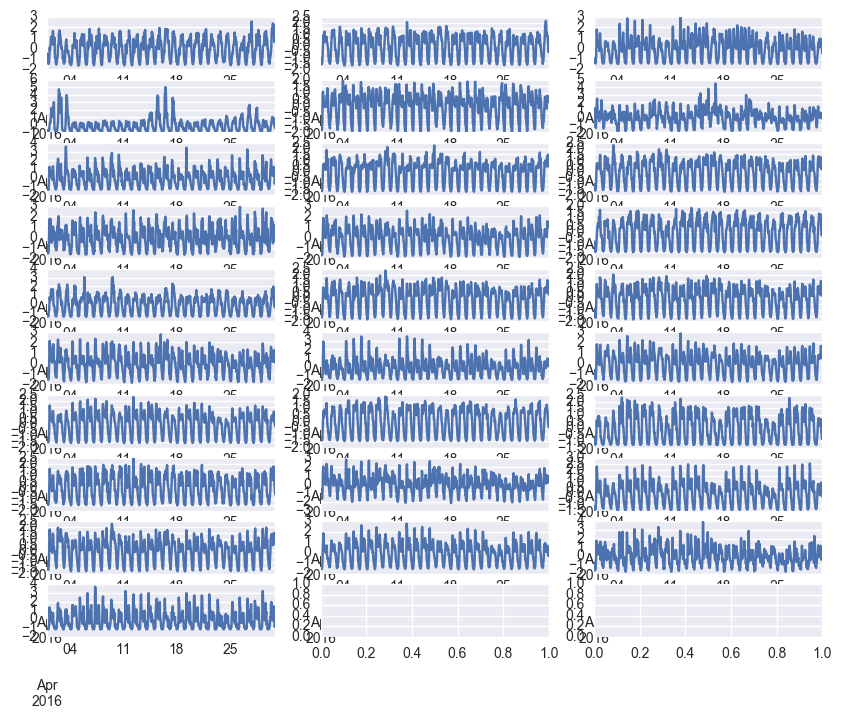

In [20]:
fig, ax = plt.subplots(nrows=10, ncols=3, figsize=(10,8))
for i, j in enumerate(sc_df_t.index[res == 3]):
    sc_df[j].plot(ax=ax[i/3, i%3])

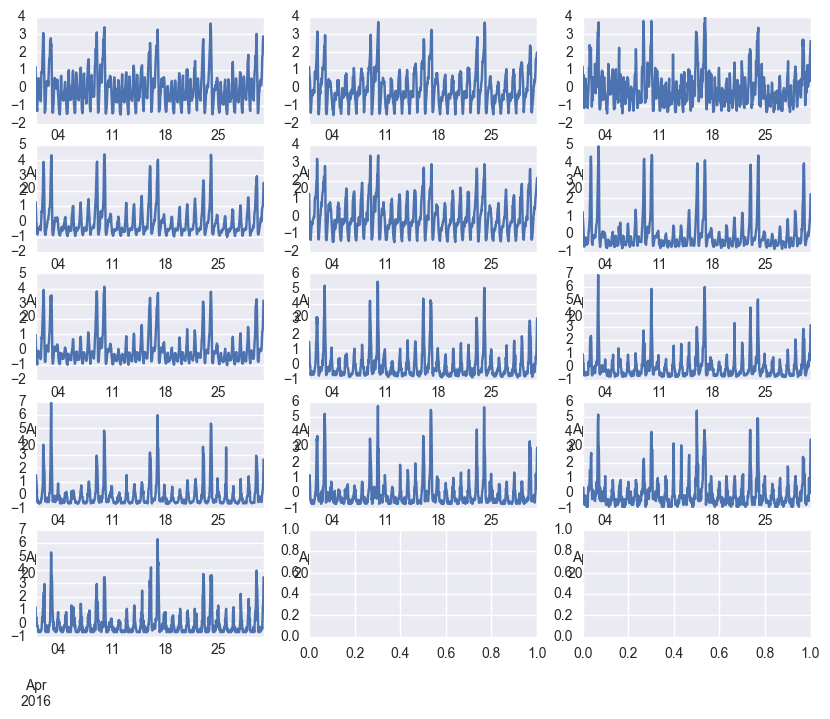

In [21]:
fig, ax = plt.subplots(nrows=5, ncols=3, figsize=(10,8))
for i, j in enumerate(sc_df_t.index[res == 4]):
    sc_df[j].plot(ax=ax[i/3, i%3])

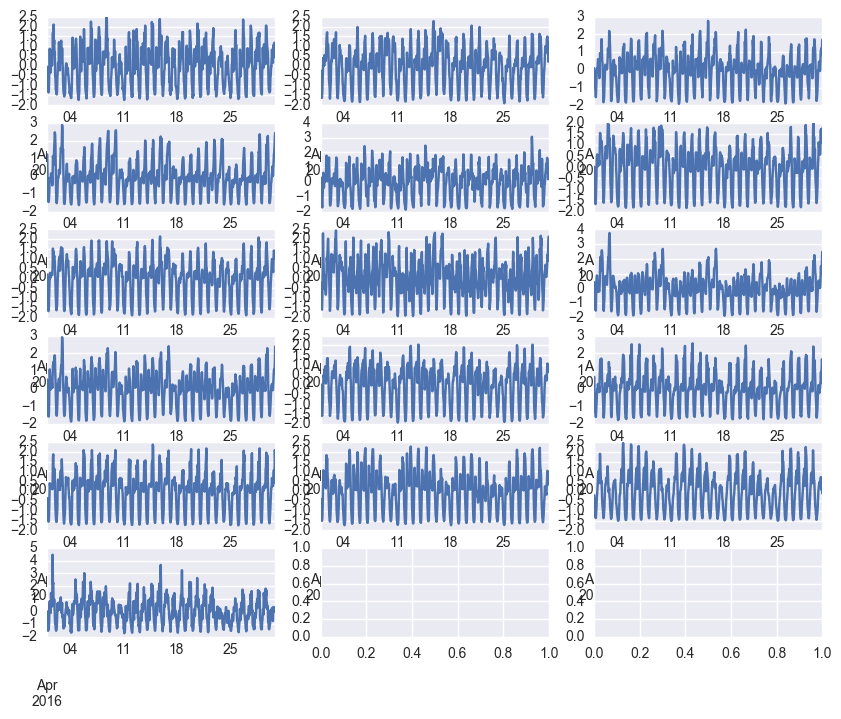

In [23]:
fig, ax = plt.subplots(nrows=6, ncols=3, figsize=(10,8))
for i, j in enumerate(sc_df_t.index[res == 5]):
    sc_df[j].plot(ax=ax[i/3, i%3])

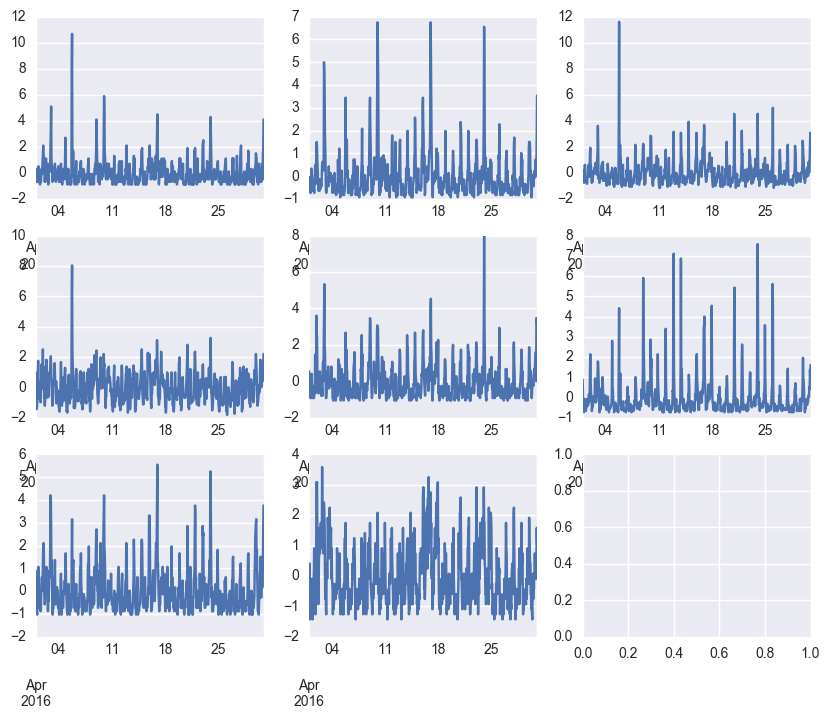

In [24]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(10,8))
for i, j in enumerate(sc_df_t.index[res == 6]):
    sc_df[j].plot(ax=ax[i/3, i%3])

Подбор наиболее типичных представителей кластеров: будем выбирать регион, который наиболее коррелирован со всеми остальными.

In [15]:
def find_most_correlated(data, regions):
    max_corr = -np.inf
    for reg1 in regions:
        corr_list = []
        for reg2 in regions:
            if reg1 == reg2:
                continue
            corr, pval = ss.pearsonr(data[reg1], data[reg2])
            corr_list.append(corr)
        mean_corr = np.array(corr_list).mean()
        if mean_corr > max_corr:
            max_corr = mean_corr
            region = reg1
    return region

In [16]:
for label in range(7):
    region = find_most_correlated(df_s, sc_df_t[res == label].index)
    print "Cluster: %d, region: %d" % (label, region)

Cluster: 0, region: 1482
Cluster: 1, region: 1387
Cluster: 2, region: 1734
Cluster: 3, region: 1333
Cluster: 4, region: 1177
Cluster: 5, region: 1180
Cluster: 6, region: 1274


Далее осуществляется подбор параметров для каждого представителя. Ниже указана общая схема, с помощью которой осуществлялся подбор.

In [17]:
ts_df = pd.DataFrame(df_s[1274].values, index = df_s.index, columns = ['val'])
ts_df.head()

,val
2016-04-01 00:00:00,13.0
2016-04-01 01:00:00,10.0
2016-04-01 02:00:00,9.0
2016-04-01 03:00:00,2.0
2016-04-01 04:00:00,1.0


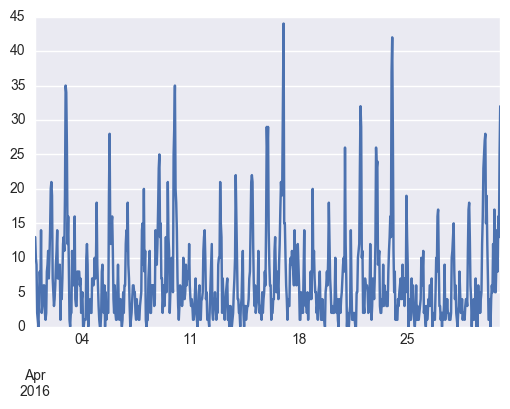

In [18]:
ts_df.val.plot()

In [19]:
str_reg = 'val ~ '
str_var = ''
num_end = 49
length = ts_df.shape[0]
for i in range(1, num_end+1):
    #if i%7 == 0:
     #   continue
    sin = "s_" + str(i)
    cos = "c_" + str(i)
    ts_df[sin] = np.sin(2*np.pi*i*np.arange(1, length+1)/168.0)
    ts_df[cos] = np.cos(2*np.pi*i*np.arange(1, length+1)/168.0)
    str_var = str_var + sin + ' + '
    if i != num_end:
        str_var = str_var + cos + ' + '
    else:
        str_var = str_var + cos
ts_df.head()

,val,s_1,c_1,s_2,c_2,s_3,c_3,s_4,c_4,s_5,...,s_45,c_45,s_46,c_46,s_47,c_47,s_48,c_48,s_49,c_49
2016-04-01 00:00:00,13.0,0.037391,0.999301,0.074730,0.997204,0.111964,0.993712,0.149042,0.988831,0.185912,...,0.993712,-0.111964,0.988831,-0.149042,0.982566,-0.185912,0.974928,-0.222521,0.965926,-0.258819
2016-04-01 01:00:00,10.0,0.074730,0.997204,0.149042,0.988831,0.222521,0.974928,0.294755,0.955573,0.365341,...,-0.222521,-0.974928,-0.294755,-0.955573,-0.365341,-0.930874,-0.433884,-0.900969,-0.500000,-0.866025
2016-04-01 02:00:00,9.0,0.111964,0.993712,0.222521,0.974928,0.330279,0.943883,0.433884,0.900969,0.532032,...,-0.943883,0.330279,-0.900969,0.433884,-0.846724,0.532032,-0.781831,0.623490,-0.707107,0.707107
2016-04-01 03:00:00,2.0,0.149042,0.988831,0.294755,0.955573,0.433884,0.900969,0.563320,0.826239,0.680173,...,0.433884,0.900969,0.563320,0.826239,0.680173,0.733052,0.781831,0.623490,0.866025,0.500000
2016-04-01 04:00:00,1.0,0.185912,0.982566,0.365341,0.930874,0.532032,0.846724,0.680173,0.733052,0.804598,...,0.846724,-0.532032,0.733052,-0.680173,0.593820,-0.804598,0.433884,-0.900969,0.258819,-0.965926


In [20]:
m1 = smf.ols(str_reg + str_var, data=ts_df)
fitted = m1.fit(cov_type='HC1')
print fitted.summary()

                            OLS Regression Results                            
Dep. Variable:                    val   R-squared:                       0.802
Model:                            OLS   Adj. R-squared:                  0.771
Method:                 Least Squares   F-statistic:                     24.68
Date:                Sun, 26 Feb 2017   Prob (F-statistic):          1.51e-159
Time:                        22:22:35   Log-Likelihood:                -1806.6
No. Observations:                 720   AIC:                             3811.
Df Residuals:                     621   BIC:                             4265.
Df Model:                          98                                         
Covariance Type:                  HC1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      6.7582      0.117     57.866      0.0

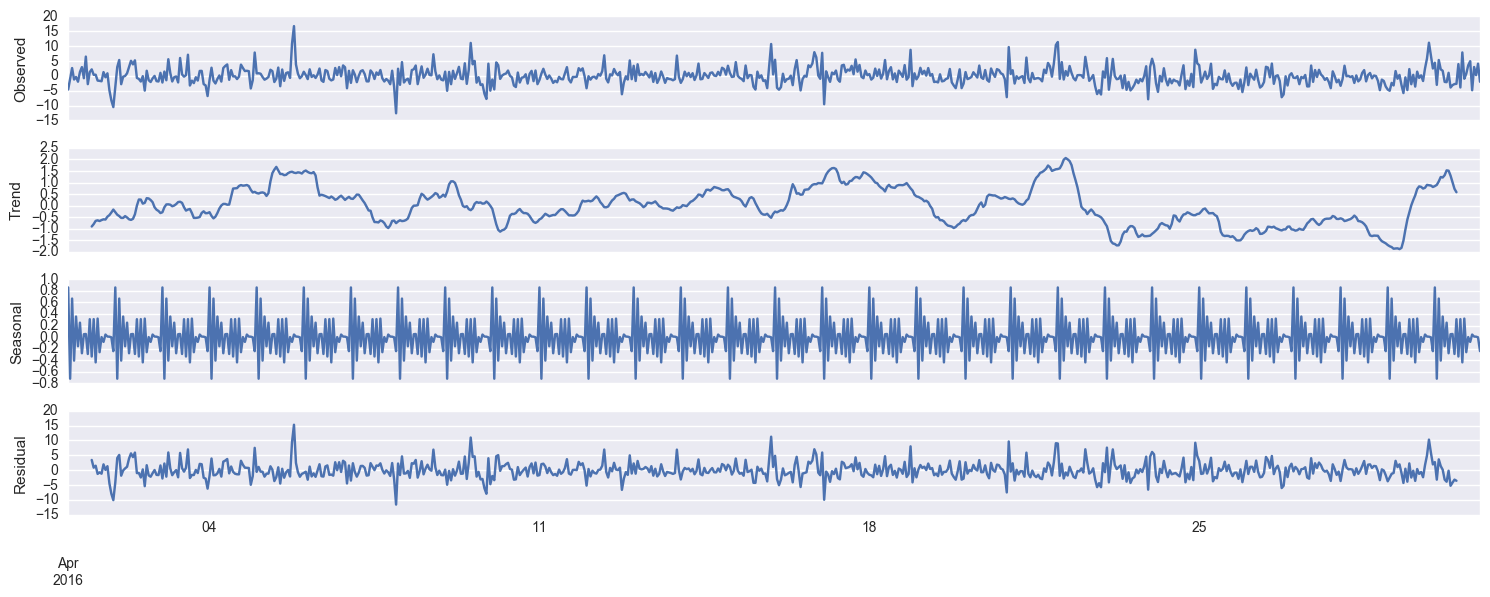

In [21]:
plt.figure(figsize(15,6))
sm.tsa.seasonal_decompose(fitted.resid, freq=24).plot();

In [22]:
# Weekday dummy-variables
ts_df['monday'] = [1 if date.weekday() == 0 else 0 for date in ts_df.index]
ts_df['tuesday'] = [1 if date.weekday() == 1 else 0 for date in ts_df.index]
ts_df['wednessday'] = [1 if date.weekday() == 2 else 0 for date in ts_df.index]
ts_df['thursday'] = [1 if date.weekday() == 3 else 0 for date in ts_df.index]
ts_df['friday'] = [1 if date.weekday() == 4 else 0 for date in ts_df.index]
ts_df['saturday'] = [1 if date.weekday() == 5 else 0 for date in ts_df.index]
ts_df['sunday'] = [1 if date.weekday() == 6 else 0 for date in ts_df.index]
weekday_str = ' + tuesday + wednessday + thursday + friday + saturday + sunday'

In [23]:
m1 = smf.ols(str_reg + str_var + weekday_str, data=ts_df)
fitted = m1.fit(cov_type='HC1')
print fitted.summary()

                            OLS Regression Results                            
Dep. Variable:                    val   R-squared:                       0.807
Model:                            OLS   Adj. R-squared:                  0.774
Method:                 Least Squares   F-statistic:                     25.55
Date:                Sun, 26 Feb 2017   Prob (F-statistic):          4.36e-166
Time:                        22:22:45   Log-Likelihood:                -1798.2
No. Observations:                 720   AIC:                             3806.
Df Residuals:                     615   BIC:                             4287.
Df Model:                         104                                         
Covariance Type:                  HC1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     13.9400      3.702      3.765      0.0

In [24]:
resid = pd.DataFrame(fitted.resid, columns = ['val'], index=ts_df.index)
resid.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 720 entries, 2016-04-01 00:00:00 to 2016-04-30 23:00:00
Freq: H
Data columns (total 1 columns):
val    720 non-null float64
dtypes: float64(1)
memory usage: 11.2 KB


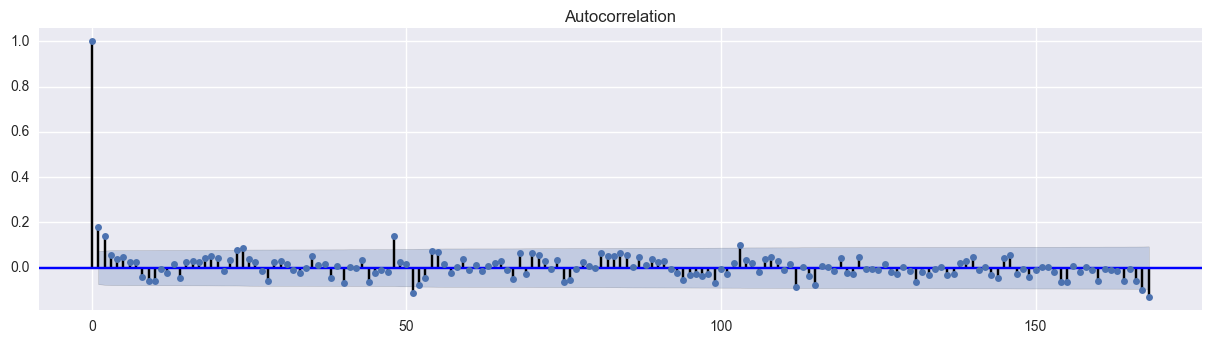

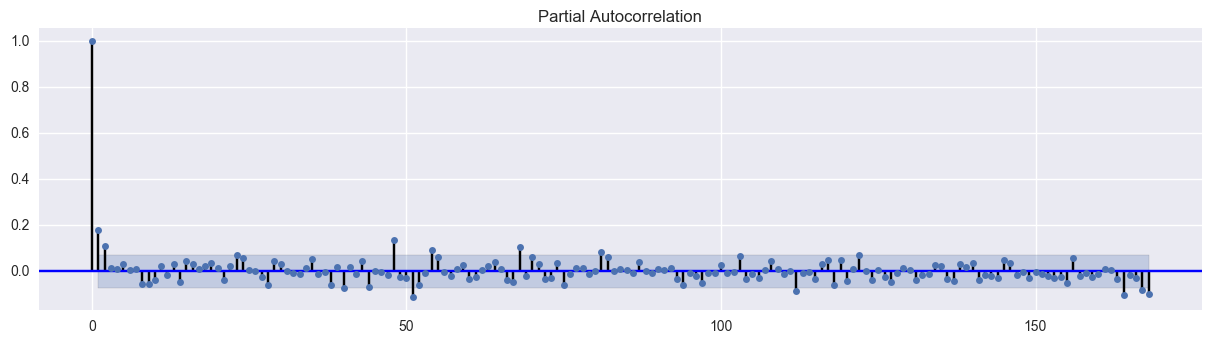

In [25]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(resid.val.values.squeeze(), lags=168, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(resid.val.values.squeeze(), lags=168, ax=ax)
pylab.show()

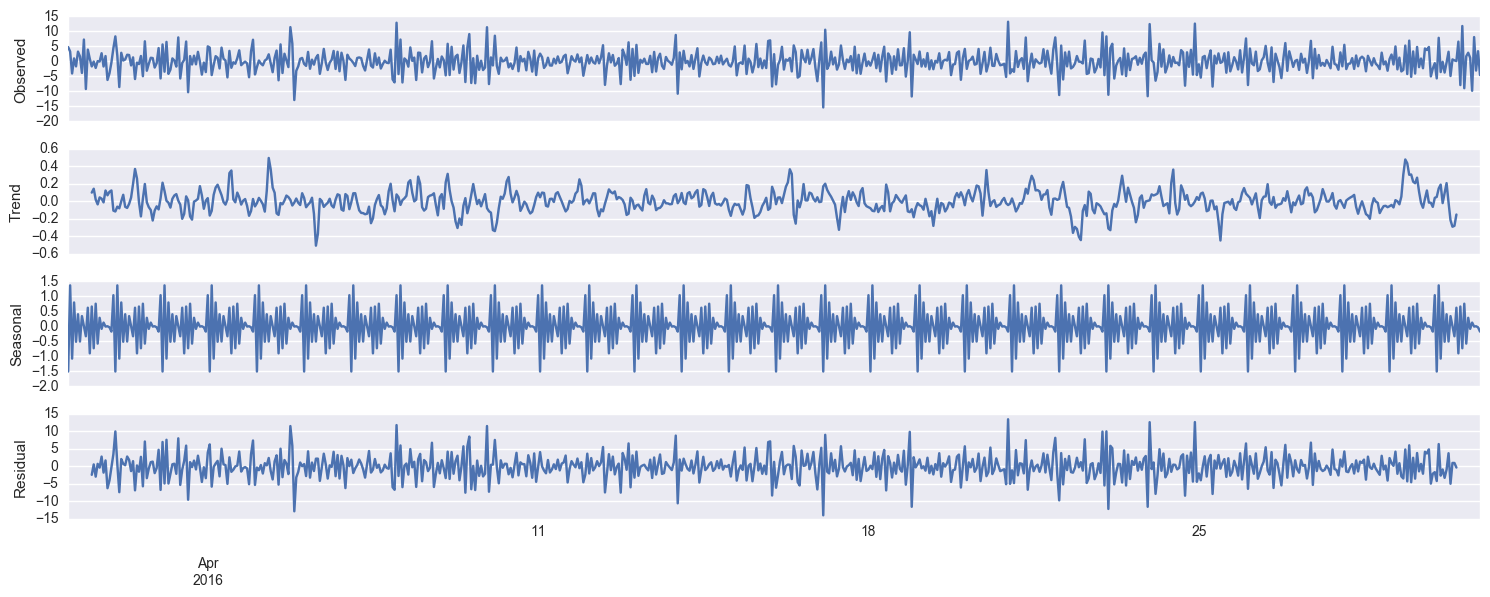

In [26]:
resid['diff_d1'] = resid.val - resid.val.shift(1)
plt.figure(figsize(15,6))
sm.tsa.seasonal_decompose(resid.diff_d1[1:], freq=24).plot();

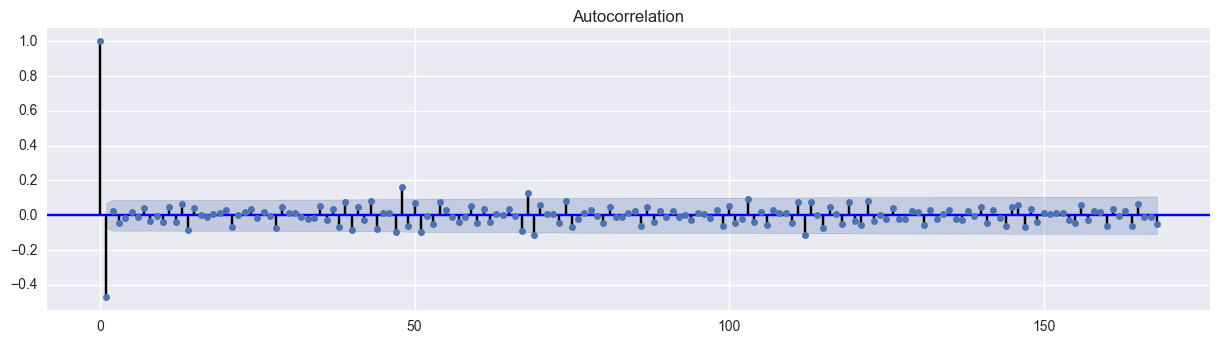

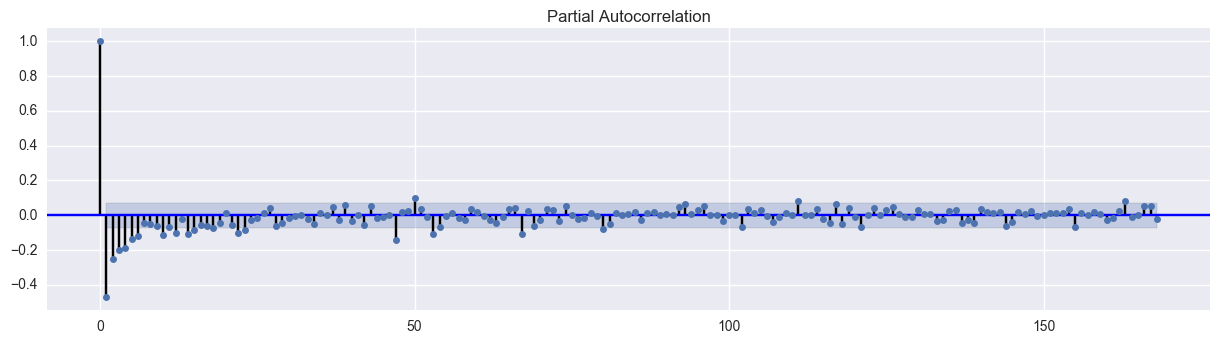

In [27]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(resid.diff_d1.values[1:].squeeze(), lags=168, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(resid.diff_d1.values[1:].squeeze(), lags=168, ax=ax)
pylab.show()

In [28]:
# Для упрощения модели ограничимся меньшим числом параметров.
ps = range(0, 3)
d = 0
qs = range(0, 3) 
Ps = range(0, 2) # ограничим для скорости вычисления
D = 0
Qs = range(0, 2)

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
print('Перебираем %d моделей'%len(parameters_list))

Перебираем 36 моделей


In [29]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for model, param in enumerate(parameters_list):
    print model, param, 
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:#resid.val, #
        model=sm.tsa.statespace.SARIMAX(resid.val, #ts_df.val, exog=ts_df[ts_df.columns[1:]], 
                                        order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 24)).fit(disp=-1)
    #выводим параметрcы, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
        print "current best",
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

0 (0, 0, 0, 0) ('wrong parameters:', (0, 0, 0, 0))
1 (0, 0, 0, 1) current best 2 (0, 0, 1, 0) current best 3 (0, 0, 1, 1) current best 4 (0, 1, 0, 0) current best 5 (0, 1, 0, 1) current best 6 (0, 1, 1, 0) current best 7 (0, 1, 1, 1) current best 8 (0, 2, 0, 0) current best 9 (0, 2, 0, 1) current best 10 (0, 2, 1, 0) current best 11 (0, 2, 1, 1) current best 12 (1, 0, 0, 0) 13 (1, 0, 0, 1) 14 (1, 0, 1, 0) 15 (1, 0, 1, 1) 16 (1, 1, 0, 0) 17 (1, 1, 0, 1) 18 (1, 1, 1, 0) 19 (1, 1, 1, 1) current best 20 (1, 2, 0, 0) 21 (1, 2, 0, 1) 22 (1, 2, 1, 0) 23 (1, 2, 1, 1) 24 (2, 0, 0, 0) 25 (2, 0, 0, 1) 26 (2, 0, 1, 0) 27 (2, 0, 1, 1) 28 (2, 1, 0, 0) 29 (2, 1, 0, 1) 30 (2, 1, 1, 0) 31 (2, 1, 1, 1) 32 (2, 2, 0, 0) 33 (2, 2, 0, 1) 34 (2, 2, 1, 0) 35 (2, 2, 1, 1)Wall time: 2min 32s



In [30]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters          aic
18  (1, 1, 1, 1)  3562.228701
26  (2, 0, 1, 1)  3562.745215
30  (2, 1, 1, 1)  3563.789924
22  (1, 2, 1, 1)  3563.814489
10  (0, 2, 1, 1)  3565.352103


Далее приводятся подобранные параметры. Так как у меня небольшой запас мощностей, то я старался выбрать модели не оптимальные, но близкие к оптимальным с меньшим числом параметров.

In [333]:
# Parameters for every cluster (p,d,q)(P,D,Q) frd, frd - fourier regression degree
param_dict = {}
param_dict[0] = [0,1,1, 1,0,1, 49]
param_dict[1] = [2,1,1, 1,0,1, 49]
param_dict[2] = [3,1,1, 1,0,0, 49]
param_dict[3] = [2,1,0, 1,0,0, 49]
param_dict[4] = [4,1,1, 0,0,0, 49]
param_dict[5] = [1,1,1, 1,0,1, 49]
param_dict[6] = [1,0,1, 1,0,1, 49]#[0,0,1, 2,0,0, 49]

In [366]:
def make_fourier_regressors(data, num_end):
    str_reg = 'val ~ '
    str_var = ''
    length = data.shape[0]
    for i in range(1, num_end+1):
        #if i%7 == 0:
         #   continue
        sin = "s_" + str(i)
        cos = "c_" + str(i)
        data[sin] = np.sin(2*np.pi*i*np.arange(1, length+1)/168.0)
        data[cos] = np.cos(2*np.pi*i*np.arange(1, length+1)/168.0)
        str_var = str_var + sin + ' + '
        if i != num_end:
            str_var = str_var + cos + ' + '
        else:
            str_var = str_var + cos
    return str_var
def make_dummy_weekday(data):
    # Weekday dummy-variables
    data['monday'] = [1 if date.weekday() == 0 else 0 for date in data.index]
    data['tuesday'] = [1 if date.weekday() == 1 else 0 for date in data.index]
    data['wednessday'] = [1 if date.weekday() == 2 else 0 for date in data.index]
    data['thursday'] = [1 if date.weekday() == 3 else 0 for date in data.index]
    data['friday'] = [1 if date.weekday() == 4 else 0 for date in data.index]
    data['saturday'] = [1 if date.weekday() == 5 else 0 for date in data.index]
    data['sunday'] = [1 if date.weekday() == 6 else 0 for date in data.index]
    weekday_str = ' + tuesday + wednessday + thursday + friday + saturday + sunday'
    return weekday_str

### Till april models

Строим модели на данных до конца апреля. Опять же таки для скорости вычисления не будем применять exog в SARIMAX - затьраты времени уменьшаются на порядок. Будем настраиваться на остатки, а далее вручную будем склеивать предсказания модели и регрессионного метода. exog существенных изменений не добавлял, а мощностей у меня под капотом не так много,чтобы с ним мучиться.

In [262]:
models_dict = {}
regres_dict = {}

In [335]:
%%time
for label in range(6,7):
    print label,
    for reg in sc_df_t[res == label].index:
        print reg, 
        #ts_df = pd.DataFrame(sc_df[reg].values, index = sc_df.index, columns = ['val'])
        ts_df = pd.DataFrame(df_s[reg].values, index = df_s.index, columns = ['val'])
        # Making regressors
        str_var = make_fourier_regressors(ts_df, param_dict[label][6])
        week_day_str = make_dummy_weekday(ts_df)
        # Linear Regression
        m1 = smf.ols(str_reg + str_var + week_day_str, data=ts_df)
        fitted = m1.fit(cov_type='HC1')
        regres_dict[reg] = fitted
        # SARIMAX for residuals fitted.resid, #
        model=sm.tsa.statespace.SARIMAX(fitted.resid, #ts_df.val, exog=ts_df[ts_df.columns[1:]], 
                                            order=(param_dict[label][0], 
                                                   param_dict[label][1],
                                                   param_dict[label][2]), 
                                            seasonal_order=(param_dict[label][3], 
                                                            param_dict[label][4], 
                                                            param_dict[label][5], 24)).fit(disp=-1)
        models_dict[reg] = model
        # Saving data to pickle files for god's sake
        fitted.save("./regressor/regressor_" + str(reg) + ".pkl")
        model.save("./arima/arima_" + str(reg) + ".pkl")

 6 1221 1222 1223 1224 1272 1273 1274 1380Wall time: 8min 34s



In [ ]:
# load data from pkl files

In [336]:
for reg in sc_df_t.index:
    print reg,
    with open("./regressor/regressor_" + str(reg) + ".pkl", "rb") as fid:
        regres_dict[reg] = pickle.load(fid)
    with open("./arima/arima_" + str(reg) + ".pkl", "rb") as fid:
        models_dict[reg] = pickle.load(fid)

1075 1076 1077 1125 1126 1127 1128 1129 1130 1131 1132 1172 1173 1174 1175 1176 1177 1178 1179 1180 1181 1182 1183 1184 1221 1222 1223 1224 1225 1227 1228 1229 1230 1231 1232 1233 1234 1235 1272 1273 1274 1278 1279 1280 1281 1282 1283 1284 1285 1286 1287 1326 1327 1331 1332 1333 1334 1335 1336 1337 1338 1339 1376 1377 1378 1380 1382 1383 1384 1385 1386 1387 1388 1389 1390 1426 1431 1434 1435 1436 1437 1438 1439 1441 1442 1480 1482 1483 1530 1532 1533 1580 1630 1684 1733 1734 1783 2068 2069 2118 2119 2168


### Till may models

Строим модели на данных до конца мая.

In [337]:
df_s_may = df.loc['2016-04-01 00:00:00':'2016-05-31 23:00:00']
df_s_may.tail()

,1075,1076,1077,1125,1126,1127,1128,1129,1130,1131,...,1630,1684,1733,1734,1783,2068,2069,2118,2119,2168
2016-05-31 19:00:00,106.0,167.0,171.0,88.0,293.0,401.0,433.0,284.0,428.0,222.0,...,1.0,5.0,9.0,347.0,304.0,104.0,15.0,172.0,17.0,103.0
2016-05-31 20:00:00,99.0,166.0,165.0,65.0,301.0,350.0,404.0,351.0,444.0,190.0,...,0.0,16.0,10.0,336.0,271.0,154.0,23.0,284.0,116.0,111.0
2016-05-31 21:00:00,84.0,173.0,107.0,78.0,256.0,340.0,416.0,426.0,493.0,173.0,...,0.0,37.0,5.0,289.0,306.0,167.0,26.0,212.0,84.0,130.0
2016-05-31 22:00:00,83.0,98.0,127.0,94.0,174.0,345.0,415.0,411.0,490.0,144.0,...,1.0,20.0,9.0,392.0,299.0,123.0,12.0,222.0,53.0,123.0
2016-05-31 23:00:00,34.0,77.0,58.0,53.0,118.0,211.0,331.0,338.0,434.0,121.0,...,2.0,12.0,10.0,430.0,153.0,157.0,17.0,192.0,77.0,132.0


In [350]:
models_dict_may = {}
regres_dict_may = {}

In [344]:
%%time
for label in range(7):
    print label,
    for reg in sc_df_t[res == label].index:
        print reg, 
        #ts_df = pd.DataFrame(sc_df[reg].values, index = sc_df.index, columns = ['val'])
        ts_df = pd.DataFrame(df_s_may[reg].values, index = df_s_may.index, columns = ['val'])
        # Making regressors
        str_var = make_fourier_regressors(ts_df, param_dict[label][6])
        week_day_str = make_dummy_weekday(ts_df)
        # Linear Regression
        m1 = smf.ols(str_reg + str_var + week_day_str, data=ts_df)
        fitted = m1.fit(cov_type='HC1')
        regres_dict_may[reg] = fitted
        # SARIMAX for residuals fitted.resid, #
        model=sm.tsa.statespace.SARIMAX(fitted.resid, #ts_df.val, exog=ts_df[ts_df.columns[1:]], 
                                            order=(param_dict[label][0], 
                                                   param_dict[label][1],
                                                   param_dict[label][2]), 
                                            seasonal_order=(param_dict[label][3], 
                                                            param_dict[label][4], 
                                                            param_dict[label][5], 24)).fit(disp=-1)
        models_dict_may[reg] = model
        # Saving data to pickle files for god's sake
        fitted.save("./regressor_may/regressor_may_" + str(reg) + ".pkl")
        model.save("./arima_may/arima_may_" + str(reg) + ".pkl")

 0 1431 1480 1482 1483 1530 1532 1533 1580 1630 1 1172 1173 1174 1175 1225 1278 1339 1387 1388 1389 1390 1435 1436 1437 1438 1439 1441 1442 2 1382 1684 1733 1734 1783 2068 2069 2118 2119 2168 3 1075 1076 1077 1132 1181 1183 1184 1234 1235 1279 1280 1283 1284 1285 1286 1287 1331 1332 1333 1334 1335 1336 1337 1383 1384 1385 1386 1434 4 1129 1130 1176 1177 1178 1227 1228 1326 1327 1376 1377 1378 1426 5 1125 1126 1127 1128 1131 1179 1180 1182 1229 1230 1231 1232 1233 1281 1282 1338 6 1221 1222 1223 1224 1272 1273 1274 1380Wall time: 1h 27min 55s



In [345]:
# load data from pkl files

In [ ]:
for reg in sc_df_t.index:
    print reg,
    with open("./regressor_may/regressor_may_" + str(reg) + ".pkl", "rb") as fid:
        regres_dict_may[reg] = pickle.load(fid)
    with open("./arima_may/arima_may_" + str(reg) + ".pkl", "rb") as fid:
        models_dict_may[reg] = pickle.load(fid)

### Model for all data

Данные за июнь.

In [339]:
df_s_june = df.loc['2016-04-01 00:00:00':]
df_s_june.tail()

,1075,1076,1077,1125,1126,1127,1128,1129,1130,1131,...,1630,1684,1733,1734,1783,2068,2069,2118,2119,2168
2016-06-30 19:00:00,116.0,190.0,135.0,132.0,395.0,308.0,401.0,336.0,496.0,260.0,...,2.0,44.0,4.0,297.0,311.0,104.0,9.0,142.0,96.0,1.0
2016-06-30 20:00:00,104.0,142.0,149.0,141.0,333.0,368.0,390.0,385.0,560.0,247.0,...,1.0,27.0,7.0,288.0,344.0,103.0,24.0,209.0,145.0,0.0
2016-06-30 21:00:00,151.0,162.0,145.0,135.0,359.0,422.0,460.0,541.0,672.0,259.0,...,2.0,21.0,9.0,287.0,307.0,185.0,9.0,213.0,142.0,1.0
2016-06-30 22:00:00,106.0,168.0,103.0,125.0,317.0,476.0,405.0,508.0,578.0,259.0,...,3.0,19.0,5.0,358.0,387.0,169.0,12.0,206.0,146.0,0.0
2016-06-30 23:00:00,85.0,130.0,86.0,113.0,256.0,428.0,483.0,531.0,631.0,210.0,...,9.0,0.0,7.0,323.0,110.0,147.0,38.0,173.0,119.0,0.0


Регрессионные признаки.

In [383]:
reg_df = pd.DataFrame(index=df.loc['2016-04-01 00:00:00':'2016-05-31 23:00:00'].index)
make_fourier_regressors(reg_df, 49)
make_dummy_weekday(reg_df)
reg_df.head()

,s_1,c_1,s_2,c_2,s_3,c_3,s_4,c_4,s_5,c_5,...,c_48,s_49,c_49,monday,tuesday,wednessday,thursday,friday,saturday,sunday
2016-04-01 00:00:00,0.037391,0.999301,0.074730,0.997204,0.111964,0.993712,0.149042,0.988831,0.185912,0.982566,...,-0.222521,0.965926,-0.258819,0,0,0,0,1,0,0
2016-04-01 01:00:00,0.074730,0.997204,0.149042,0.988831,0.222521,0.974928,0.294755,0.955573,0.365341,0.930874,...,-0.900969,-0.500000,-0.866025,0,0,0,0,1,0,0
2016-04-01 02:00:00,0.111964,0.993712,0.222521,0.974928,0.330279,0.943883,0.433884,0.900969,0.532032,0.846724,...,0.623490,-0.707107,0.707107,0,0,0,0,1,0,0
2016-04-01 03:00:00,0.149042,0.988831,0.294755,0.955573,0.433884,0.900969,0.563320,0.826239,0.680173,0.733052,...,0.623490,0.866025,0.500000,0,0,0,0,1,0,0
2016-04-01 04:00:00,0.185912,0.982566,0.365341,0.930874,0.532032,0.846724,0.680173,0.733052,0.804598,0.593820,...,-0.900969,0.258819,-0.965926,0,0,0,0,1,0,0


## May prediction, $Q_{may}$ counting

Расчитываем функционал ошибки на предсказаниях для мая.

In [443]:
pd.date_range('2016-04-30 23:00:00', '2016-05-31 17:00:00', freq='H').size

739

In [495]:
Q_may = 0
R = 102
denom = 1.0/(R*739*6)

In [496]:
%%time
for label in range(7):
    print label,
    for reg in sc_df_t[res == label].index:
        print reg, 
        # loading regressor
        regressor = regres_dict[reg]
        # fitting SARIMAX
        ts_df = pd.DataFrame(df_s_may[reg].values, index = df_s_may.index, columns = ['val'])
        # Making regressors
        ts_df = pd.DataFrame(df_s_june[reg].values, index = df_s_june.index, columns = ['val'])
        fitted = regressor.predict(reg_df)
        resid = ts_df.val - fitted
        model_fitted=sm.tsa.statespace.SARIMAX(resid, #ts_df.val, exog=ts_df[ts_df.columns[1:]], 
                                                    order=(param_dict[label][0], 
                                                           param_dict[label][1],
                                                           param_dict[label][2]), 
                                                    seasonal_order=(param_dict[label][3], 
                                                                    param_dict[label][4], 
                                                                    param_dict[label][5], 24)).filter(models_dict[reg].params)
        for time in range(719, 719+739):
            reg_pred = regressor.predict(reg_df.iloc[time:time+7])
            model_pred = model_fitted.predict(time, time+6, dynamic=True)
            prediction = reg_pred + model_pred
            sum_abs = np.abs(df_s_may.iloc[time+1:time+1+6][reg] - prediction[1:7]).sum()
            Q_may += denom*sum_abs

Intermediate result:  0
0 1431 1480 1482 1483 1530 1532 1533 1580 1630 Intermediate result:  0.290471635068
1 1172 1173 1174 1175 1225 1278 1339 1387 1388 1389 1390 1435 1436 1437 1438 1439 1441 1442 Intermediate result:  1.0511165158
2 1382 1684 1733 1734 1783 2068 2069 2118 2119 2168 Intermediate result:  2.60653430483
3 1075 1076 1077 1132 1181 1183 1184 1234 1235 1279 1280 1283 1284 1285 1286 1287 1331 1332 1333 1334 1335 1336 1337 1383 1384 1385 1386 1434 Intermediate result:  10.0455285548
4 1129 1130 1176 1177 1178 1227 1228 1326 1327 1376 1377 1378 1426 Intermediate result:  12.810027934
5 1125 1126 1127 1128 1131 1179 1180 1182 1229 1230 1231 1232 1233 1281 1282 1338 Intermediate result:  20.3923032906
6 1221 1222 1223 1224 1272 1273 1274 1380


Выводим посчитанную ошибку прогноза.

In [499]:
print "Q_may = %lf" % Q_may

Q_may = 20.719552


## June prediction

Регрессионные признаки.

In [566]:
reg_df = pd.DataFrame(index=df.loc['2016-04-01 00:00:00':'2016-06-30 23:00:00'].index)
make_fourier_regressors(reg_df, 49)
make_dummy_weekday(reg_df)
reg_df.tail()

,s_1,c_1,s_2,c_2,s_3,c_3,s_4,c_4,s_5,c_5,...,c_48,s_49,c_49,monday,tuesday,wednessday,thursday,friday,saturday,sunday
2016-06-30 19:00:00,-1.490423e-01,0.988831,-2.947552e-01,0.955573,-4.338837e-01,0.900969,-5.633201e-01,0.826239,-6.801727e-01,0.733052,...,0.623490,-8.660254e-01,0.500000,0,0,0,1,0,0,0
2016-06-30 20:00:00,-1.119645e-01,0.993712,-2.225209e-01,0.974928,-3.302791e-01,0.943883,-4.338837e-01,0.900969,-5.320321e-01,0.846724,...,0.623490,7.071068e-01,0.707107,0,0,0,1,0,0,0
2016-06-30 21:00:00,-7.473009e-02,0.997204,-1.490423e-01,0.988831,-2.225209e-01,0.974928,-2.947552e-01,0.955573,-3.653410e-01,0.930874,...,-0.900969,5.000000e-01,-0.866025,0,0,0,1,0,0,0
2016-06-30 22:00:00,-3.739119e-02,0.999301,-7.473009e-02,0.997204,-1.119645e-01,0.993712,-1.490423e-01,0.988831,-1.859116e-01,0.982566,...,-0.222521,-9.659258e-01,-0.258819,0,0,0,1,0,0,0
2016-06-30 23:00:00,3.921346e-15,1.000000,7.842691e-15,1.000000,-1.665767e-14,1.000000,1.568538e-14,1.000000,-3.723669e-14,1.000000,...,1.000000,-3.194448e-13,1.000000,0,0,0,1,0,0,0


In [510]:
reg_df.index[1463:1463+715]

DatetimeIndex(['2016-05-31 23:00:00', '2016-06-01 00:00:00',
               '2016-06-01 01:00:00', '2016-06-01 02:00:00',
               '2016-06-01 03:00:00', '2016-06-01 04:00:00',
               '2016-06-01 05:00:00', '2016-06-01 06:00:00',
               '2016-06-01 07:00:00', '2016-06-01 08:00:00',
               ...
               '2016-06-30 08:00:00', '2016-06-30 09:00:00',
               '2016-06-30 10:00:00', '2016-06-30 11:00:00',
               '2016-06-30 12:00:00', '2016-06-30 13:00:00',
               '2016-06-30 14:00:00', '2016-06-30 15:00:00',
               '2016-06-30 16:00:00', '2016-06-30 17:00:00'],
              dtype='datetime64[ns]', length=715, freq='H')

In [546]:
t = reg_df.index[720]

t.strftime('%Y-%m-%d_%H')

In [549]:
str(1232) + '_' + t.strftime('%Y-%m-%d') + '_' + str(t.hour) + '_' + str(1)

'1232_2016-05-01_0_1'

In [590]:
Q_june = 0
denom = 1.0/(R*715*6)

In [591]:
all_predictions = []
all_ids = []

Считаем предсказания.

In [592]:
%%time
Q_june_inter = []
for label in range(7):
    Q_june_inter.append(Q_june)
    # saving intermediate data
    with open(str(label)+"_res.txt", 'w') as fid:
        fid.write(str(Q_june))
    print label
    for reg in sc_df_t[res == label].index:
        print reg, 
        # loading regressor
        with open("./regressor_may/regressor_may_" + str(reg) + ".pkl",'rb') as fid:
            regressor = pickle.load(fid)
        # fitting SARIMAX
        ts_df = pd.DataFrame(df_s_june[reg].values, index = df_s_june.index, columns = ['val'])
        fitted = regressor.predict(reg_df)
        resid = ts_df.val - fitted
        # Loading SARIMAX model
        with open("./arima_may/arima_may_" + str(reg) + ".pkl",'rb') as fid:
            model_1 = pickle.load(fid)
        model_fitted=sm.tsa.statespace.SARIMAX(resid, #ts_df.val, exog=ts_df[ts_df.columns[1:]], 
                                                    order=(param_dict[label][0], 
                                                           param_dict[label][1],
                                                           param_dict[label][2]), 
                                                    seasonal_order=(param_dict[label][3], 
                                                                    param_dict[label][4], 
                                                                    param_dict[label][5], 24)).filter(model_1.params)
        for time in range(1463, 1463+715):
            reg_pred = regressor.predict(reg_df.iloc[time:time+7])
            model_pred = model_fitted.predict(time, time+6, dynamic=True)
            prediction = reg_pred + model_pred
            t = reg_df.index[time]
            for ind, pred in enumerate(prediction[1:7]):
                all_predictions.append(pred)
                all_ids.append(str(reg) + '_' + t.strftime('%Y-%m-%d') + '_' + str(t.hour) + '_' + str(ind+1))
            sum_abs = np.abs(df_s_june.iloc[time+1:time+1+6][reg] - prediction[1:7]).sum()
            Q_june += denom*sum_abs

0
1431 1480 1482 1483 1530 1532 1533 1580 1630 1
1172 1173 1174 1175 1225 1278 1339 1387 1388 1389 1390 1435 1436 1437 1438 1439 1441 1442 2
1382 1684 1733 1734 1783 2068 2069 2118 2119 2168 3
1075 1076 1077 1132 1181 1183 1184 1234 1235 1279 1280 1283 1284 1285 1286 1287 1331 1332 1333 1334 1335 1336 1337 1383 1384 1385 1386 1434 4
1129 1130 1176 1177 1178 1227 1228 1326 1327 1376 1377 1378 1426 5
1125 1126 1127 1128 1131 1179 1180 1182 1229 1230 1231 1232 1233 1281 1282 1338 6
1221 1222 1223 1224 1272 1273 1274 1380Wall time: 4h 28min 31s



In [599]:
pred_df = pd.DataFrame(all_predictions, index=all_ids, columns=['y'])
pred_df.index.name = 'id'
pred_df.to_csv("submission.csv", sep=',')

Ссылка на submission https://inclass.kaggle.com/c/yellowtaxi/leaderboard?submissionId=4222917 

Ник Rapscallion.